# Installs & Imports

In [1]:
!pip install -q statsforecast mlforecast neuralforecast coreforecast datasetsforecast utilsforecast dask[dataframe]

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import logging

from utilsforecast.plotting import plot_series
from utilsforecast.losses import *
from datasetsforecast.m4 import M4, M4Evaluation, M4Info

from statsforecast import StatsForecast
from statsforecast.models import (
    HoltWinters,
    DynamicOptimizedTheta,
    SeasonalNaive,
    AutoETS,
    AutoARIMA,
    AutoTBATS,
    RandomWalkWithDrift
)

from mlforecast import MLForecast
from mlforecast.target_transforms import Differences
from mlforecast.utils import PredictionIntervals

import lightgbm as lgb
import xgboost as xgb
from sklearn.linear_model import Lasso, LinearRegression, Ridge
from sklearn.ensemble import RandomForestRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import (
    mean_squared_error,
    root_mean_squared_error,
    mean_absolute_error,
    mean_absolute_percentage_error
)

import torch
from neuralforecast import NeuralForecast
from neuralforecast.losses.pytorch import MQLoss
from neuralforecast.models import LSTM, NHITS

# Data Loading

In [3]:
# Load M4 data
train = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly.csv')
test = pd.read_csv('https://auto-arima-results.s3.amazonaws.com/M4-Hourly-test.csv').rename(columns={'y': 'y_test'})

In [4]:
# Training data
print("Training Data:")
display(train.head())
print("\n")
print("Test Data:")
display(test.head())

Training Data:


unique_id  ds      y
0        H1   1  605.0
1        H1   2  586.0
2        H1   3  586.0
3        H1   4  559.0
4        H1   5  511.0



Test Data:


unique_id   ds  y_test
0        H1  701   619.0
1        H1  702   565.0
2        H1  703   532.0
3        H1  704   495.0
4        H1  705   481.0

In [5]:
# Select random n_series
n_series = 4
uids = train['unique_id'].drop_duplicates().sample(n=n_series, random_state=42)
train = train.query('unique_id in @uids')
test = test.query('unique_id in @uids')

In [6]:
# Print lengths
print(f"Train: {len(train)}")
print(f"Test: {len(test)}")

Train: 3060
Test: 192


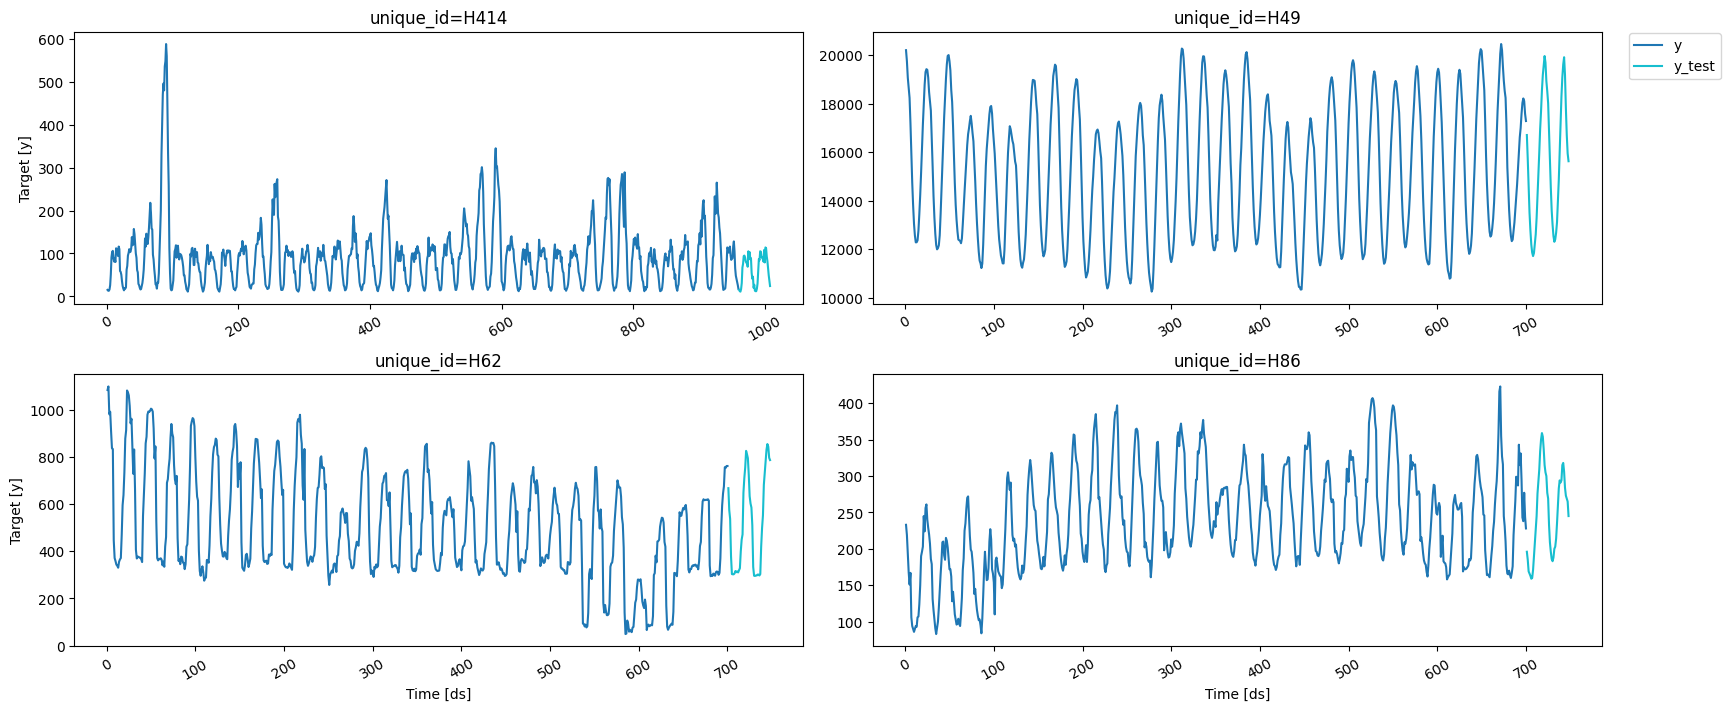

In [7]:
# Visualize the selected series
test_copy = test.copy()
test_renamed = test_copy.rename(columns={'y': 'y_test'})
plot_series(train, test_renamed, models=['y_test'], plot_random=False)

In [8]:
# Set season length
season_length=24

# Set the CI levels
levels = [80, 90]

# Set horizon
horizon = 48

# StatsForecast

In [9]:
# List of StatsForecast models
sf_models = [
    AutoETS(season_length=season_length),
    AutoARIMA(season_length=season_length),
    AutoTBATS(season_length=season_length),
    HoltWinters(season_length=season_length),
    SeasonalNaive(season_length=season_length),
    DynamicOptimizedTheta(season_length=season_length),
    RandomWalkWithDrift()
]

In [10]:
# List of StatsForecast model names
sf_model_names = [
    "AutoETS",
    "AutoARIMA",
    "AutoTBATS",
    "HoltWinters",
    "SeasonalNaive",
    "DynamicOptimizedTheta",
    "RandomWalkWithDrift"
]

In [11]:
# SF object
sf = StatsForecast(
    models=sf_models,
    freq=1
)

In [12]:
# Get the forecasts
sf_forecasts = sf.forecast(
    df=train,
    h=horizon,
    level=levels
)
sf_forecasts.head()

unique_id   ds    AutoETS  AutoETS-lo-90  AutoETS-lo-80  AutoETS-hi-80  \
0      H414  961  21.023303      10.379483      12.730405      29.316202   
1      H414  962  25.045304       8.169011      11.896511      38.194098   
2      H414  963  29.067305       6.080582      11.157705      46.976905   
3      H414  964  33.089306       3.777803      10.251893      55.926720   
4      H414  965  37.111307       1.143221       9.087563      65.135051   

   AutoETS-hi-90  AutoARIMA  AutoARIMA-lo-90  AutoARIMA-lo-80  ...  \
0      31.667123   9.449530       -25.895598       -18.088850  ...   
1      41.921598  15.022739       -36.806084       -25.358550  ...   
2      52.054028  21.173215       -45.278845       -30.601447  ...   
3      62.400809  26.490626       -52.312864       -34.907382  ...   
4      73.079394  40.558474       -48.219747       -28.611126  ...   

   DynamicOptimizedTheta  DynamicOptimizedTheta-lo-80  \
0              11.193660                     5.744094   
1               8.848328                     2.364294   
2               7.922244                     0.173440   
3               9.925361                    -0.060659   
4              14.485620                    -1.922378   

   DynamicOptimizedTheta-hi-80  DynamicOptimizedTheta-lo-90  \
0                    17.809505                     4.557054   
1                    15.437240                     0.918404   
2                    14.848673                    -2.371101   
3                    18.121313                    -3.122330   
4                    30.290529                    -5.113911   

   DynamicOptimizedTheta-hi-90        RWD  RWD-lo-80  RWD-lo-90  RWD-hi-80  \
0                    19.564533  17.002086 -13.814607 -22.550711  47.818778   
1                    17.129989  17.004171 -26.599906 -38.961056  60.608248   
2                    16.698153  17.006257 -36.425392 -51.572522  70.437905   
3                    21.153981  17.008342 -44.721270 -62.220757  78.737954   
4                    34.307382  17.010428 -52.041201 -71.616379  86.062056   

    RWD-hi-90  
0   56.554882  
1   72.969398  
2   85.585035  
3   96.237441  
4  105.637234  

[5 rows x 37 columns]

In [13]:
# Merge onto test set
test_sf = test_copy.merge(sf_forecasts, how='left', on=['unique_id', 'ds'])

In [14]:
# Rename RWD to RandomWalkWithDrift
test_sf.rename(columns={
    'RWD': 'RandomWalkWithDrift',
    'RWD-lo-80': 'RandomWalkWithDrift-lo-80',
    'RWD-hi-80': 'RandomWalkWithDrift-hi-80',
    'RWD-lo-90': 'RandomWalkWithDrift-lo-90',
    'RWD-hi-90': 'RandomWalkWithDrift-hi-90'
    },
    inplace=True
)
test_sf.head()

unique_id   ds  y_test    AutoETS  AutoETS-lo-90  AutoETS-lo-80  \
0      H414  961    15.0  21.023303      10.379483      12.730405   
1      H414  962    12.0  25.045304       8.169011      11.896511   
2      H414  963    11.0  29.067305       6.080582      11.157705   
3      H414  964    17.0  33.089306       3.777803      10.251893   
4      H414  965    31.0  37.111307       1.143221       9.087563   

   AutoETS-hi-80  AutoETS-hi-90  AutoARIMA  AutoARIMA-lo-90  ...  \
0      29.316202      31.667123   9.449530       -25.895598  ...   
1      38.194098      41.921598  15.022739       -36.806084  ...   
2      46.976905      52.054028  21.173215       -45.278845  ...   
3      55.926720      62.400809  26.490626       -52.312864  ...   
4      65.135051      73.079394  40.558474       -48.219747  ...   

   DynamicOptimizedTheta  DynamicOptimizedTheta-lo-80  \
0              11.193660                     5.744094   
1               8.848328                     2.364294   
2               7.922244                     0.173440   
3               9.925361                    -0.060659   
4              14.485620                    -1.922378   

   DynamicOptimizedTheta-hi-80  DynamicOptimizedTheta-lo-90  \
0                    17.809505                     4.557054   
1                    15.437240                     0.918404   
2                    14.848673                    -2.371101   
3                    18.121313                    -3.122330   
4                    30.290529                    -5.113911   

   DynamicOptimizedTheta-hi-90  RandomWalkWithDrift  \
0                    19.564533            17.002086   
1                    17.129989            17.004171   
2                    16.698153            17.006257   
3                    21.153981            17.008342   
4                    34.307382            17.010428   

   RandomWalkWithDrift-lo-80  RandomWalkWithDrift-lo-90  \
0                 -13.814607                 -22.550711   
1                 -26.599906                 -38.961056   
2                 -36.425392                 -51.572522   
3                 -44.721270                 -62.220757   
4                 -52.041201                 -71.616379   

   RandomWalkWithDrift-hi-80  RandomWalkWithDrift-hi-90  
0                  47.818778                  56.554882  
1                  60.608248                  72.969398  
2                  70.437905                  85.585035  
3                  78.737954                  96.237441  
4                  86.062056                 105.637234  

[5 rows x 38 columns]

Original Data:


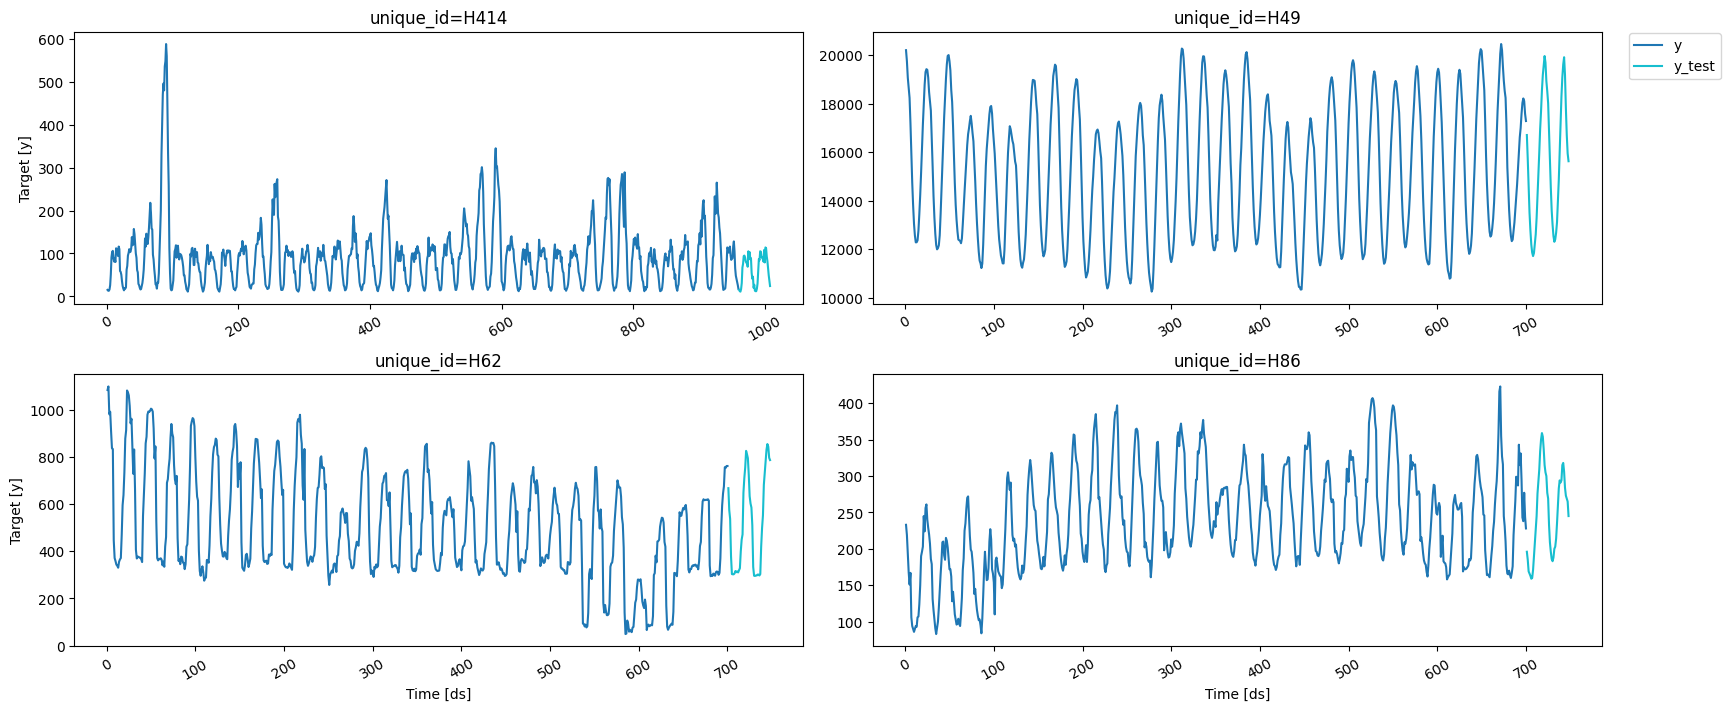


Results for AutoETS:


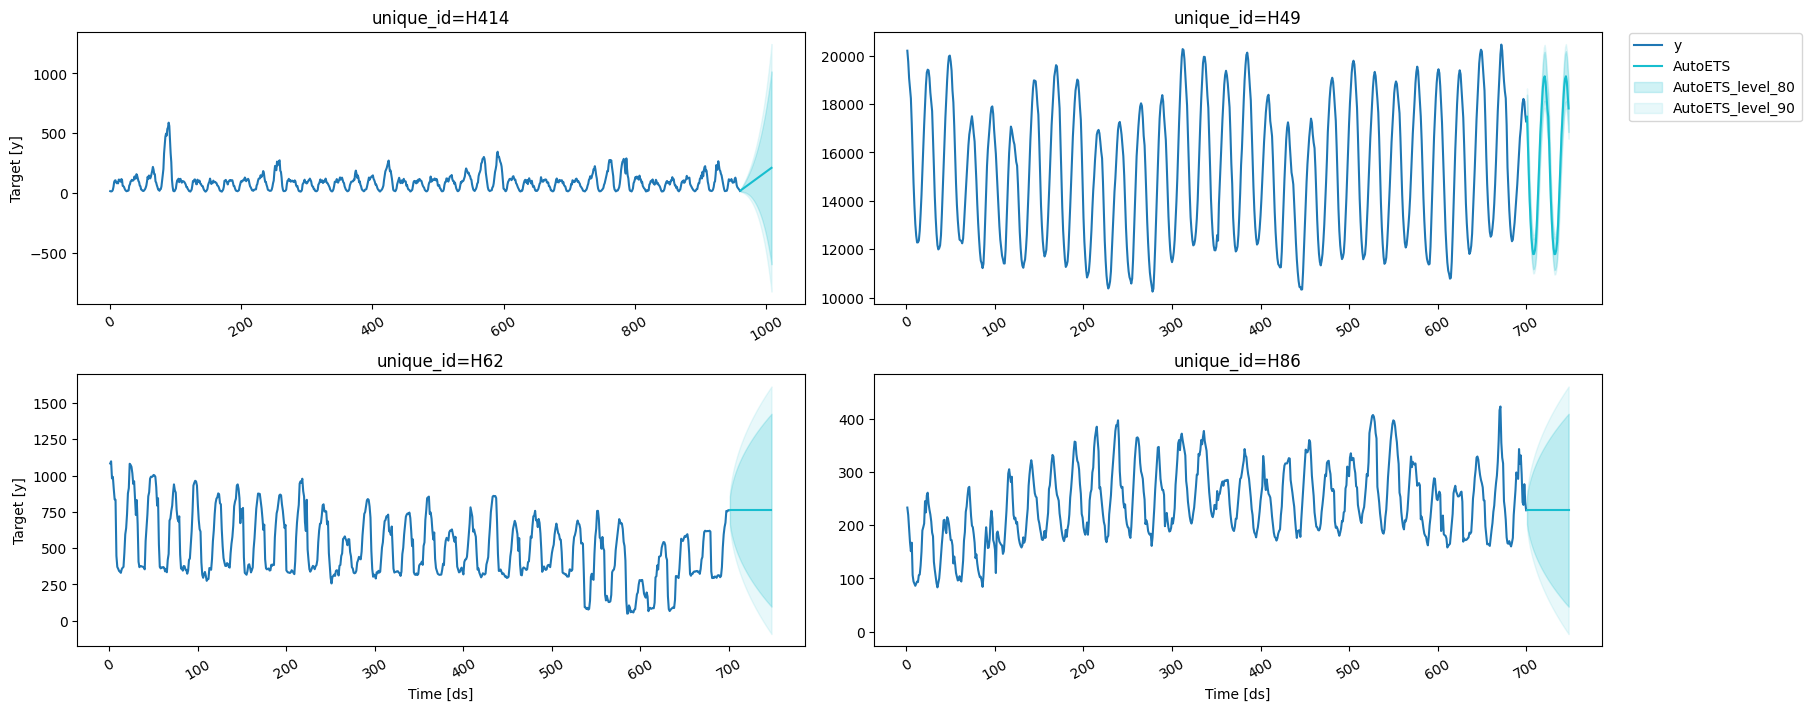


Results for AutoARIMA:


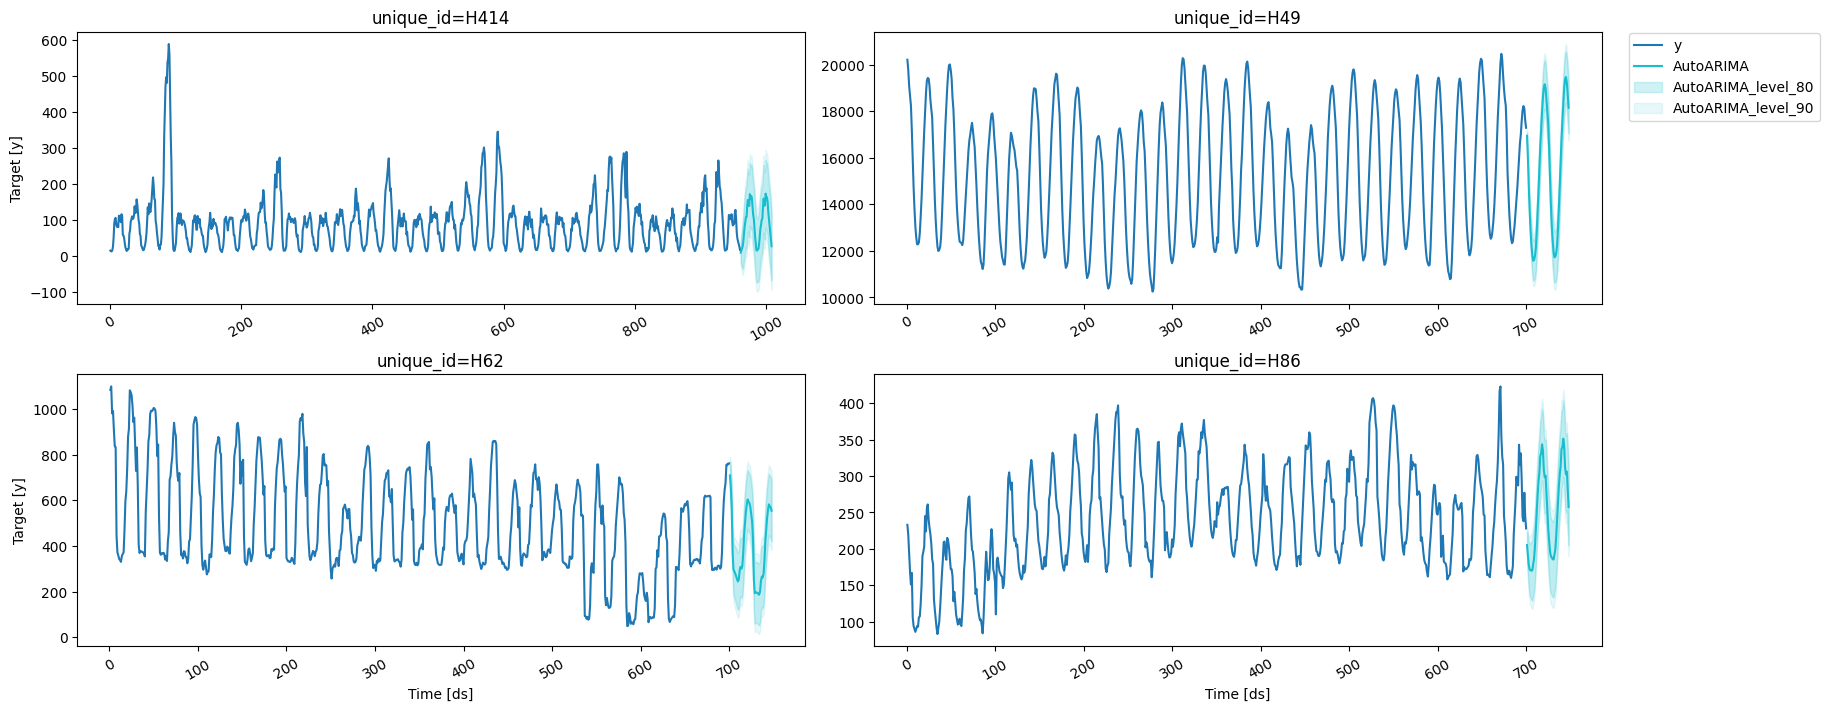


Results for AutoTBATS:


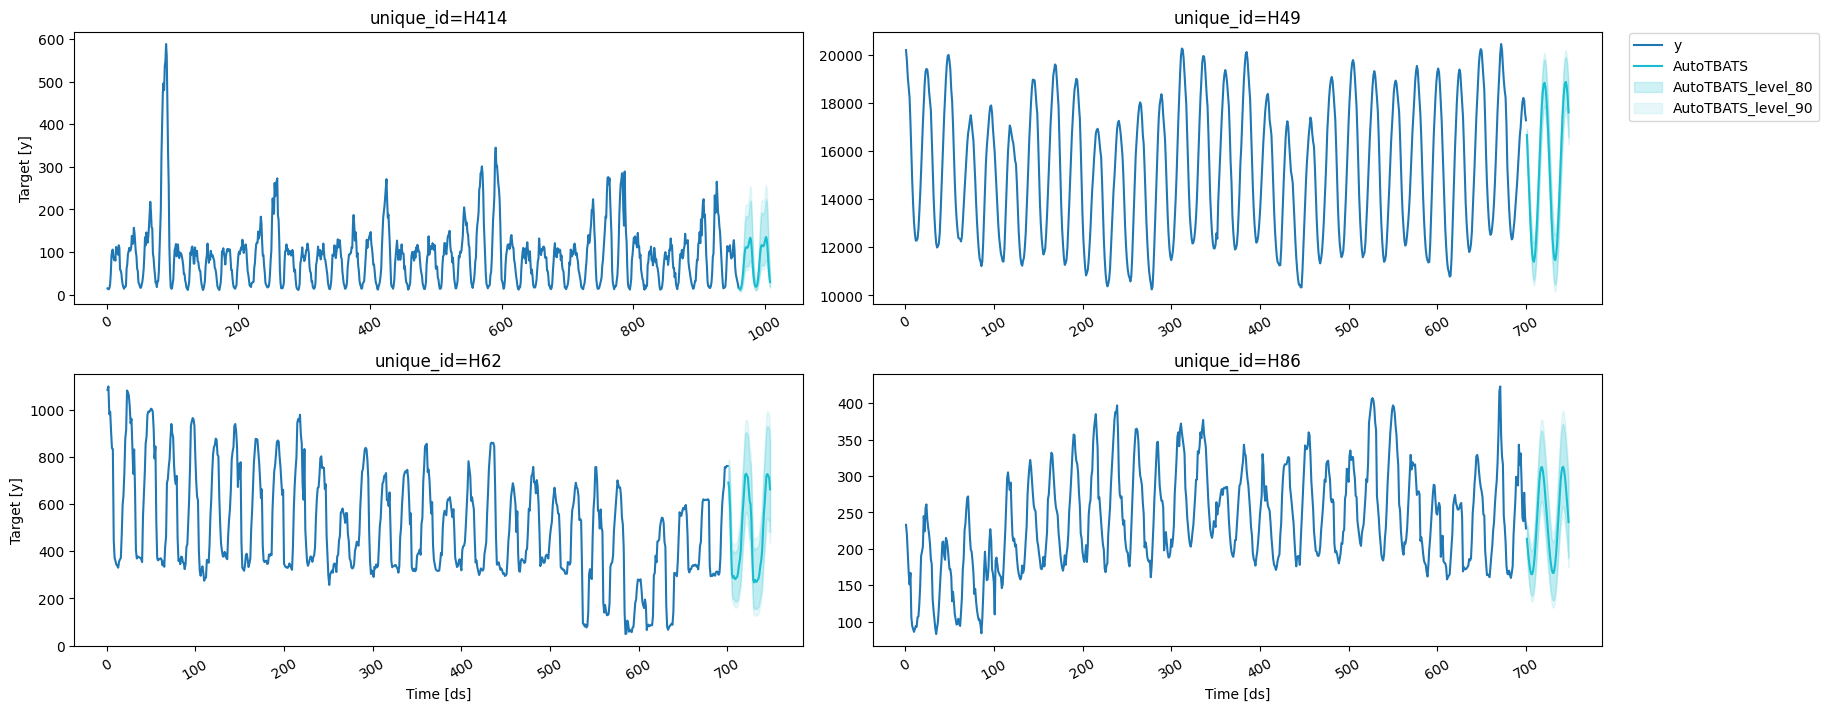


Results for HoltWinters:


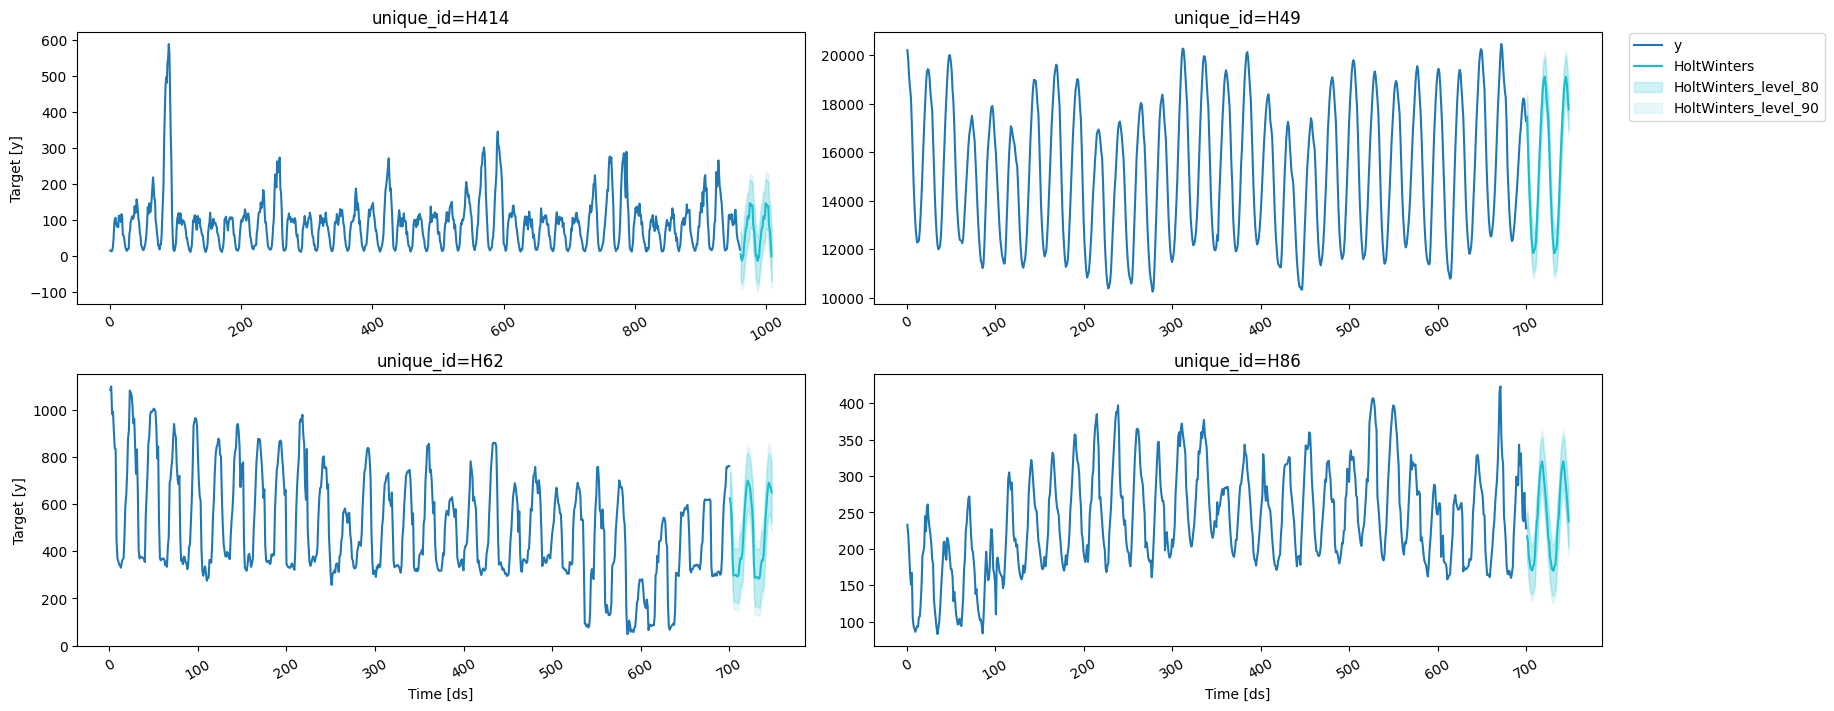


Results for SeasonalNaive:


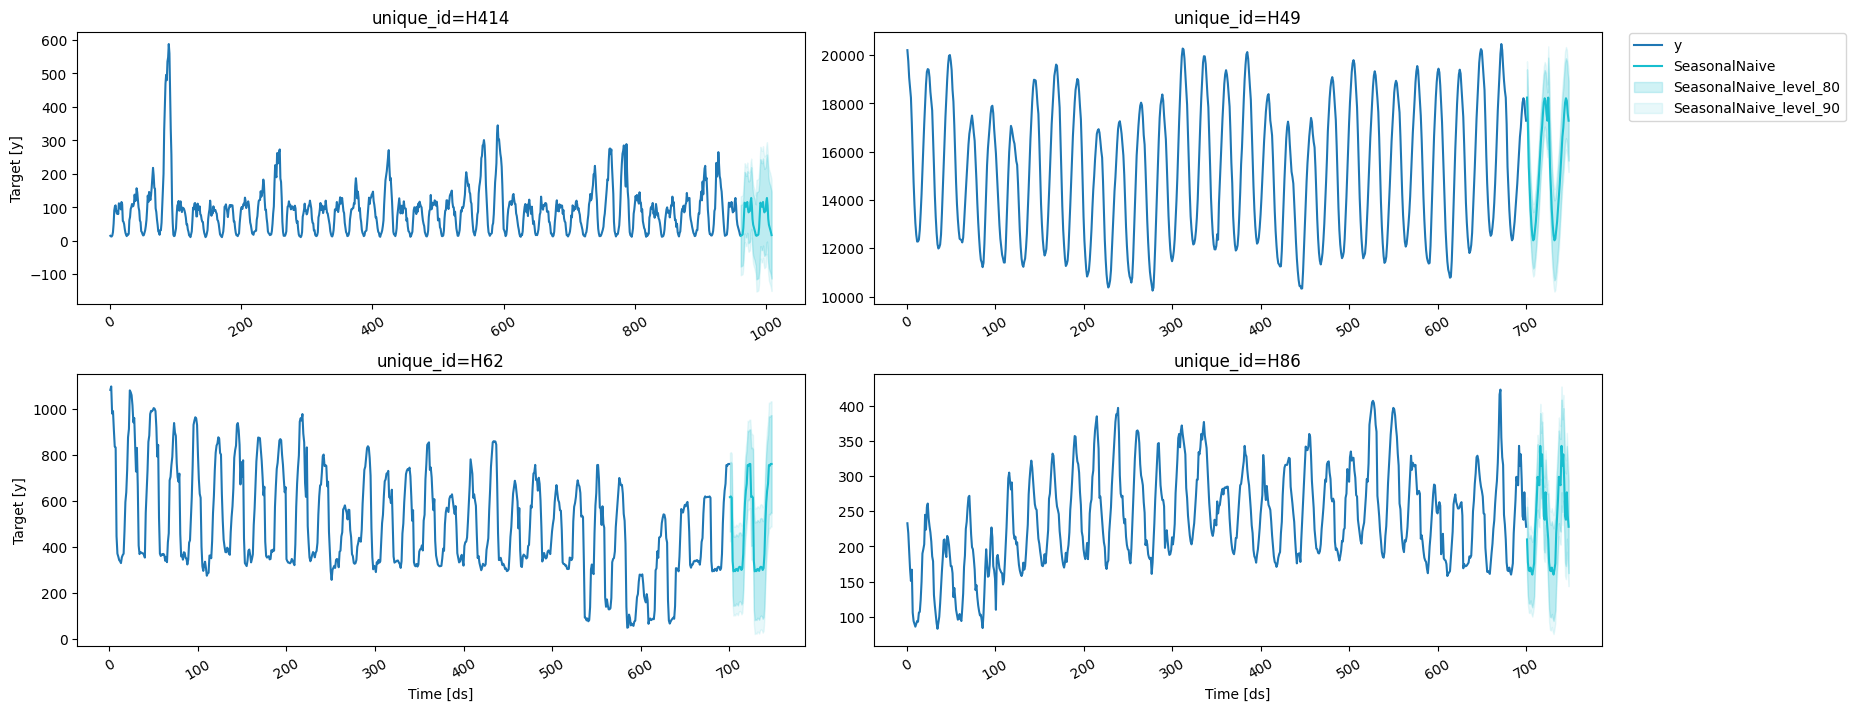


Results for DynamicOptimizedTheta:


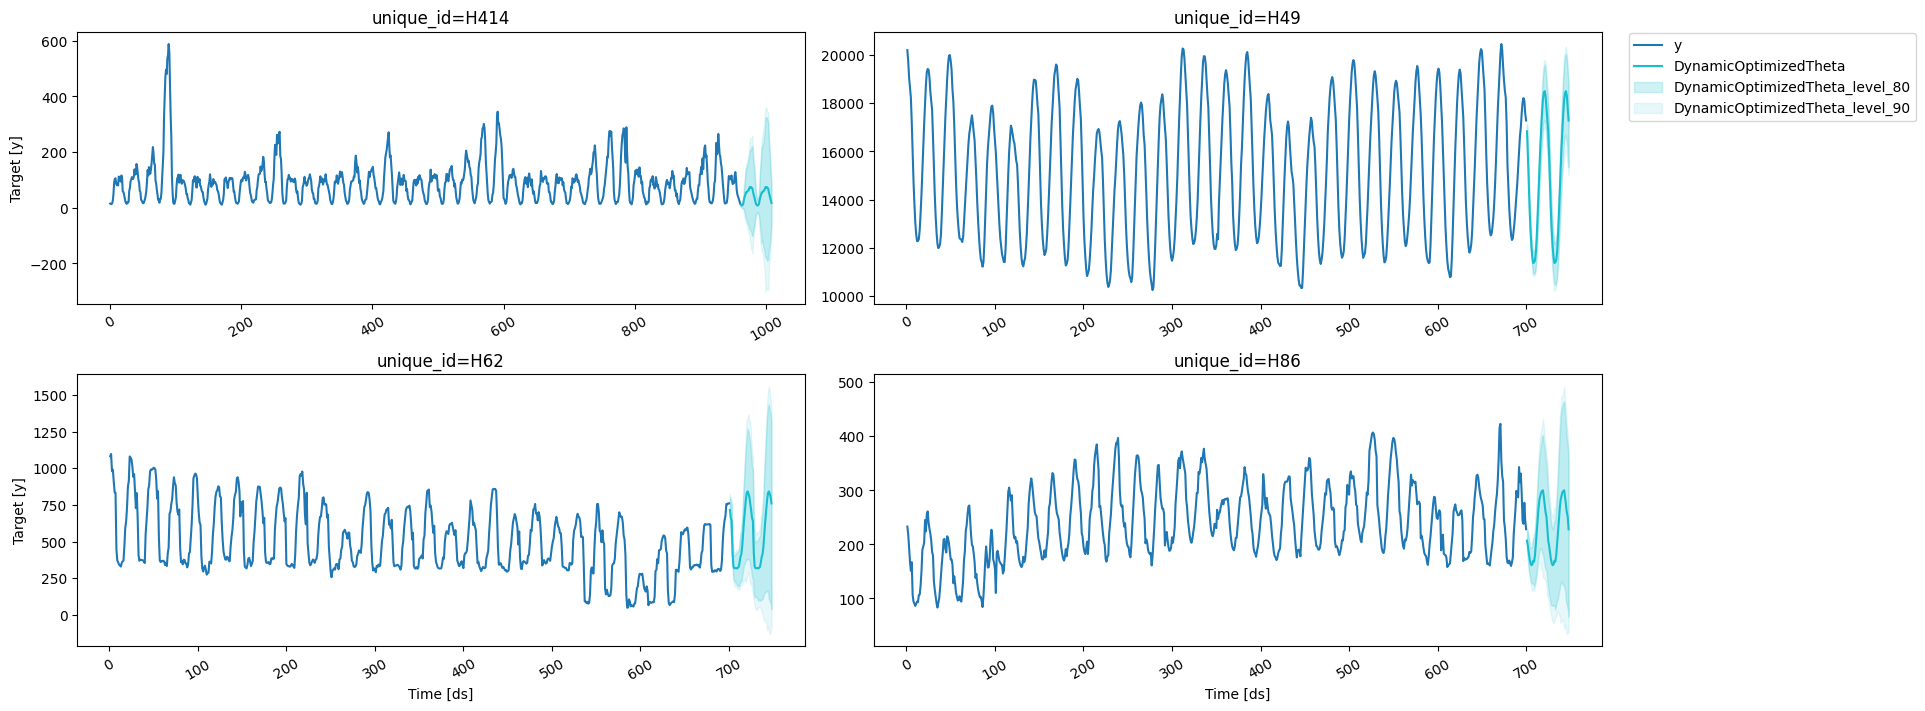


Results for RandomWalkWithDrift:


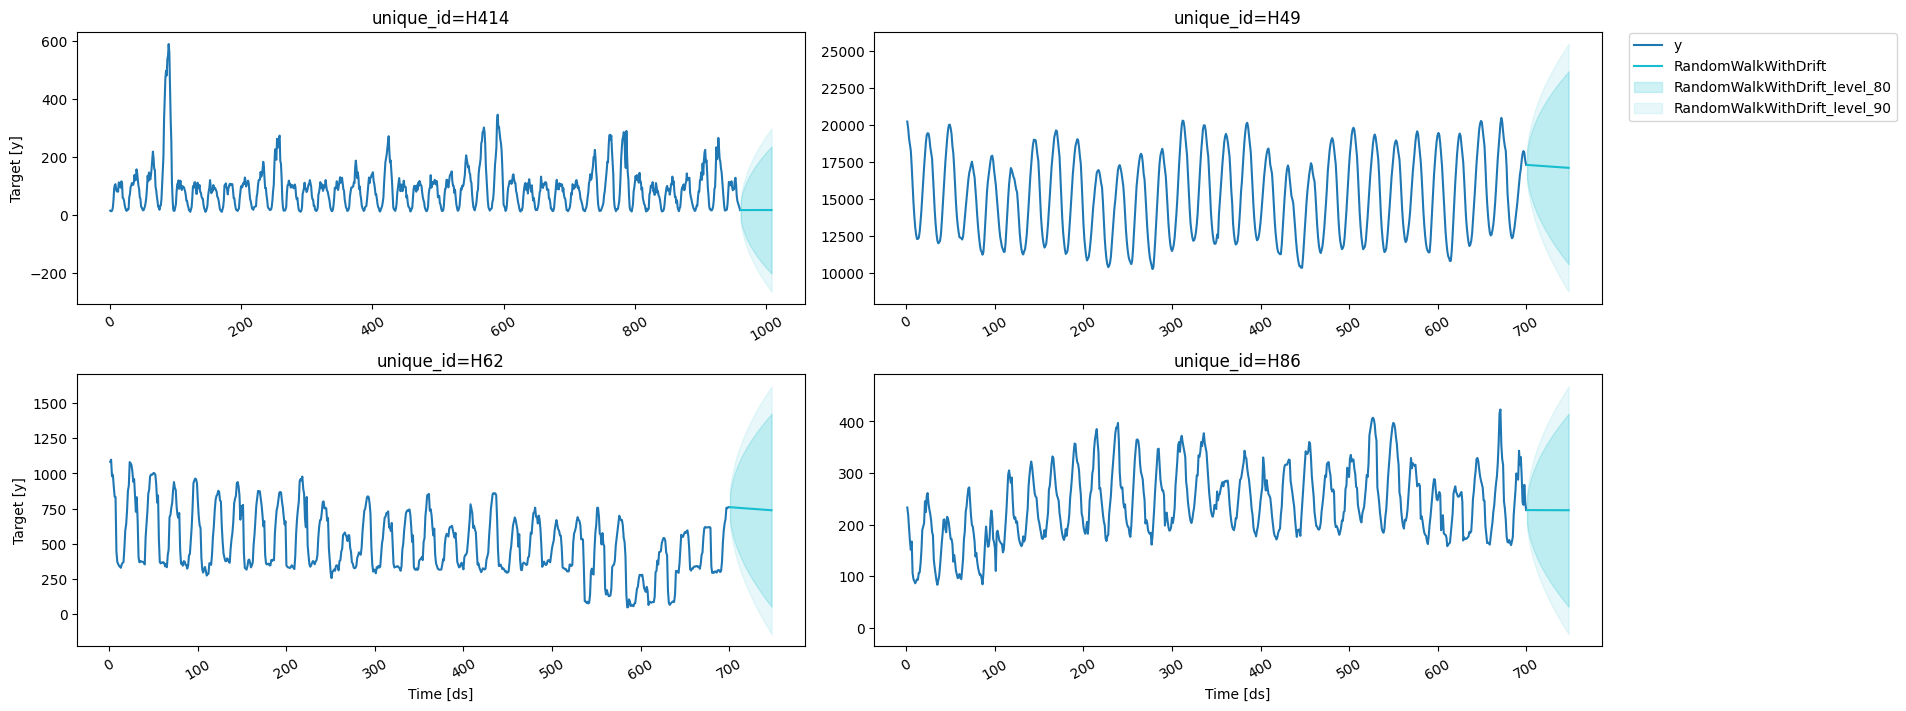

In [15]:
# Plot all results
print("Original Data:")
display(plot_series(train, test, plot_random=False, models=['y_test']))
print("\nResults for AutoETS:")
display(plot_series(train, test_sf, plot_random=False, models=["AutoETS"], level=levels))
print("\nResults for AutoARIMA:")
display(plot_series(train, test_sf, plot_random=False, models=["AutoARIMA"], level=levels))
print("\nResults for AutoTBATS:")
display(plot_series(train, test_sf, plot_random=False, models=["AutoTBATS"], level=levels))
print("\nResults for HoltWinters:")
display(plot_series(train, test_sf, plot_random=False, models=["HoltWinters"], level=levels))
print("\nResults for SeasonalNaive:")
display(plot_series(train, test_sf, plot_random=False, models=["SeasonalNaive"], level=levels))
print("\nResults for DynamicOptimizedTheta:")
display(plot_series(train, test_sf, plot_random=False, models=["DynamicOptimizedTheta"], level=levels))
print("\nResults for RandomWalkWithDrift:")
display(plot_series(train, test_sf, plot_random=False, models=["RandomWalkWithDrift"], level=levels))

In [16]:
# Extract actual test data
ts_index = 0
uid_series_to_plot = uids.iloc[ts_index]
test_series = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'y_test']]

In [17]:
# Extract the forecasts
autoets_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'AutoETS']]
autoarima_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'AutoARIMA']]
autotbats_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'AutoTBATS']]
hw_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'HoltWinters']]
sn_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'SeasonalNaive']]
doth_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'DynamicOptimizedTheta']]
rwd_forecast = test_sf[test_sf['unique_id'] == uid_series_to_plot][['ds', 'RandomWalkWithDrift']]

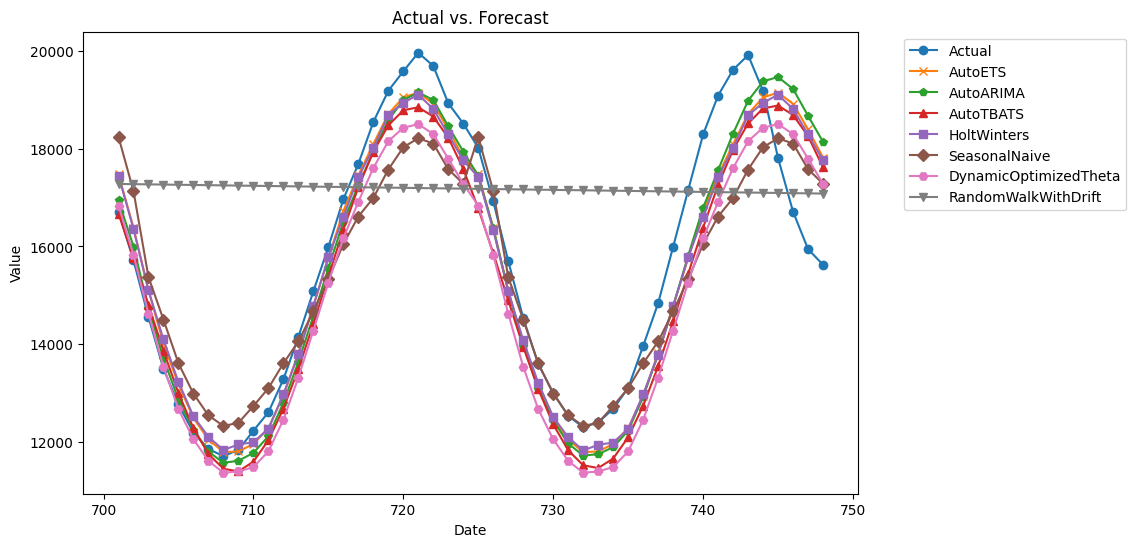

In [18]:
# Plot the ts objects
plt.figure(figsize=(10, 6))
plt.plot(test_series['ds'], test_series['y_test'], label='Actual', marker='o')
plt.plot(autoets_forecast['ds'], autoets_forecast['AutoETS'], label='AutoETS', marker='x')
plt.plot(autoarima_forecast['ds'], autoarima_forecast['AutoARIMA'], label='AutoARIMA', marker='p')
plt.plot(autotbats_forecast['ds'], autotbats_forecast['AutoTBATS'], label='AutoTBATS', marker='^')
plt.plot(hw_forecast['ds'], hw_forecast['HoltWinters'], label='HoltWinters', marker='s')
plt.plot(sn_forecast['ds'], sn_forecast['SeasonalNaive'], label='SeasonalNaive', marker='D')
plt.plot(doth_forecast['ds'], doth_forecast['DynamicOptimizedTheta'], label='DynamicOptimizedTheta', marker='H')
plt.plot(rwd_forecast['ds'], rwd_forecast['RandomWalkWithDrift'], label='RandomWalkWithDrift', marker='v')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecast')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [19]:
# Compute evaluation metrics
autoets_rmse = root_mean_squared_error(test_series['y_test'], autoets_forecast['AutoETS'])
autoets_mae = mean_absolute_error(test_series['y_test'], autoets_forecast['AutoETS'])
autoets_mape = mean_absolute_percentage_error(test_series['y_test'], autoets_forecast['AutoETS'])

autoarima_rmse = root_mean_squared_error(test_series['y_test'], autoarima_forecast['AutoARIMA'])
autoarima_mae = mean_absolute_error(test_series['y_test'], autoarima_forecast['AutoARIMA'])
autoarima_mape = mean_absolute_percentage_error(test_series['y_test'], autoarima_forecast['AutoARIMA'])

autotbats_rmse = root_mean_squared_error(test_series['y_test'], autotbats_forecast['AutoTBATS'])
autotbats_mae = mean_absolute_error(test_series['y_test'], autotbats_forecast['AutoTBATS'])
autotbats_mape = mean_absolute_percentage_error(test_series['y_test'], autotbats_forecast['AutoTBATS'])

hw_rmse = root_mean_squared_error(test_series['y_test'], hw_forecast['HoltWinters'])
hw_mae = mean_absolute_error(test_series['y_test'], hw_forecast['HoltWinters'])
hw_mape = mean_absolute_percentage_error(test_series['y_test'], hw_forecast['HoltWinters'])

sn_rmse = root_mean_squared_error(test_series['y_test'], sn_forecast['SeasonalNaive'])
sn_mae = mean_absolute_error(test_series['y_test'], sn_forecast['SeasonalNaive'])
sn_mape = mean_absolute_percentage_error(test_series['y_test'], sn_forecast['SeasonalNaive'])

doth_rmse = root_mean_squared_error(test_series['y_test'], doth_forecast['DynamicOptimizedTheta'])
doth_mae = mean_absolute_error(test_series['y_test'], doth_forecast['DynamicOptimizedTheta'])
doth_mape = mean_absolute_percentage_error(test_series['y_test'], doth_forecast['DynamicOptimizedTheta'])

rwd_rmse = root_mean_squared_error(test_series['y_test'], rwd_forecast['RandomWalkWithDrift'])
rwd_mae = mean_absolute_error(test_series['y_test'], rwd_forecast['RandomWalkWithDrift'])
rwd_mape = mean_absolute_percentage_error(test_series['y_test'], rwd_forecast['RandomWalkWithDrift'])

In [20]:
# Create DataFrame
metrics_sf = pd.DataFrame({
    'Model': sf_model_names,
    'RMSE': [autoets_rmse, autoarima_rmse, autotbats_rmse, hw_rmse, sn_rmse, doth_rmse, rwd_rmse],
    'MAE': [autoets_mae, autoarima_mae, autotbats_mae, hw_mae, sn_rmse, doth_mae, rwd_mae],
    'MAPE': [autoets_mape, autoarima_mape, autotbats_mape, hw_mape, sn_mape, doth_mape, rwd_mape]
})
display(metrics_sf)

Model         RMSE          MAE      MAPE
0                AutoETS   922.684876   733.708900  0.045778
1              AutoARIMA   964.466169   748.392122  0.046860
2              AutoTBATS  1036.048753   876.029539  0.054940
3            HoltWinters   925.170918   749.549441  0.046576
4          SeasonalNaive  1176.720150  1176.720150  0.055287
5  DynamicOptimizedTheta  1164.524739  1022.072019  0.063989
6    RandomWalkWithDrift  3079.001868  2620.732207  0.187056

# MLForecast

In [21]:
# List of MLForecast models
mlf_models = [
    lgb.LGBMRegressor(random_state=0, verbosity=-1),
    LinearRegression(),
    Lasso(),
    Ridge(),
    RandomForestRegressor(),
    xgb.XGBRegressor(random_state=0),
    KNeighborsRegressor()
]

In [22]:
# List of MLForecast model names
mlf_model_names = [
    "LGBMRegressor",
    "LinearRegression",
    "Lasso",
    "Ridge",
    "RandomForestRegressor",
    "XGBRegressor",
    "KNeighborsRegressor"
]

In [23]:
# MLF object
mlf = MLForecast(
    models=mlf_models,
    freq=1,
    target_transforms=[Differences([1])],
    lags=[24 * (i+1) for i in range(7)]
)

In [24]:
# # MLF object
# mlf = MLForecast(
#     models=mlf_models,
#     freq=1,
#     target_transforms=[Differences([24])],
#     lags=range(1, 25)
# )

In [25]:
# Fit the models
mlf.fit(
    train,
    prediction_intervals=PredictionIntervals(n_windows=10, h=horizon),
)

MLForecast(models=[LGBMRegressor, LinearRegression, Lasso, Ridge, RandomForestRegressor, XGBRegressor, KNeighborsRegressor], freq=1, lag_features=['lag24', 'lag48', 'lag72', 'lag96', 'lag120', 'lag144', 'lag168'], date_features=[], num_threads=1)

In [26]:
# Get the forecasts
mlf_forecasts = mlf.predict(
    h=horizon,
    level=levels
)
mlf_forecasts.head()

unique_id   ds  LGBMRegressor  LinearRegression      Lasso      Ridge  \
0      H414  961       6.462835          3.496489   3.493459   3.496489   
1      H414  962       4.403266          3.943132   3.937282   3.943131   
2      H414  963      -0.510484          0.911899   0.905981   0.911899   
3      H414  964       4.503303          5.983046   5.975795   5.983046   
4      H414  965      14.641050         17.770928  17.762051  17.770927   

   RandomForestRegressor  XGBRegressor  KNeighborsRegressor  \
0                   7.36      9.376446                  7.4   
1                   6.91      4.736924                  5.2   
2                   3.63      1.415798                  0.4   
3                   8.77      7.234067                  6.8   
4                  19.99     16.552845                 15.2   

   LGBMRegressor-lo-90  ...  RandomForestRegressor-hi-80  \
0           -22.447390  ...                       23.886   
1           -26.420493  ...                       31.690   
2           -30.392729  ...                       32.299   
3           -27.320407  ...                       31.538   
4           -22.197594  ...                       45.960   

   RandomForestRegressor-hi-90  XGBRegressor-lo-90  XGBRegressor-lo-80  \
0                      30.7490          -18.302602          -10.026222   
1                      35.2055          -24.786719          -23.094849   
2                      32.8655          -27.743858          -25.538023   
3                      32.8795          -21.840142          -18.495710   
4                      52.2985          -19.087173          -14.477102   

   XGBRegressor-hi-80  XGBRegressor-hi-90  KNeighborsRegressor-lo-90  \
0           28.779113           37.055493                     -19.02   
1           32.568698           34.260568                     -25.83   
2           28.369619           30.575454                     -31.62   
3           32.963843           36.308276                     -26.86   
4           47.582792           52.192863                     -25.64   

   KNeighborsRegressor-lo-80  KNeighborsRegressor-hi-80  \
0                     -12.34                      27.14   
1                     -20.02                      30.42   
2                     -29.96                      30.76   
3                     -19.22                      32.82   
4                     -15.66                      46.06   

   KNeighborsRegressor-hi-90  
0                      33.82  
1                      36.23  
2                      32.42  
3                      40.46  
4                      56.04  

[5 rows x 37 columns]

In [27]:
# Merge onto test set
test_mlf = test_copy.merge(mlf_forecasts, how='left', on=['unique_id', 'ds'])

Original Data:


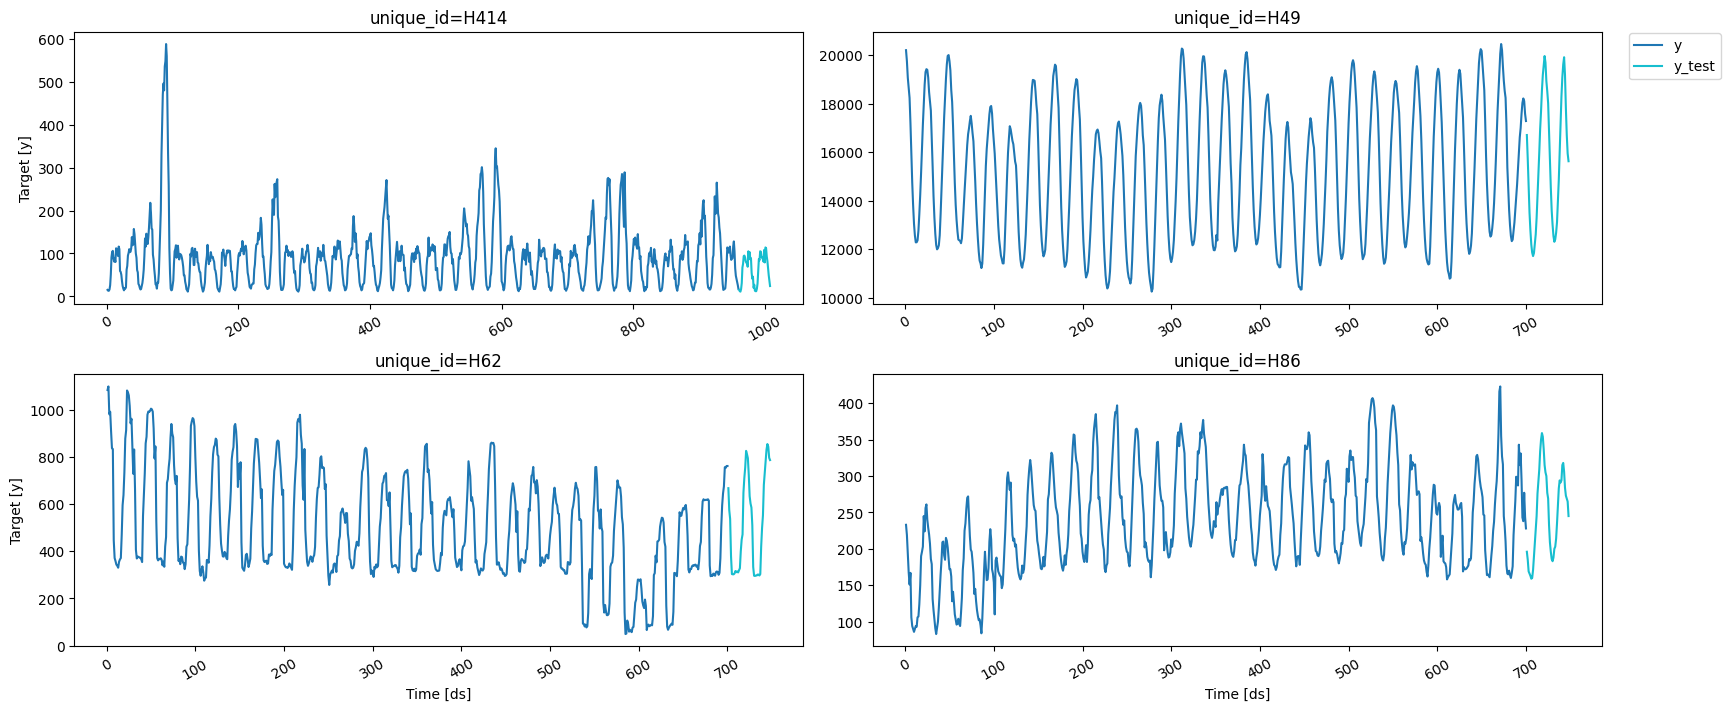


Results for LGBMRegressor:


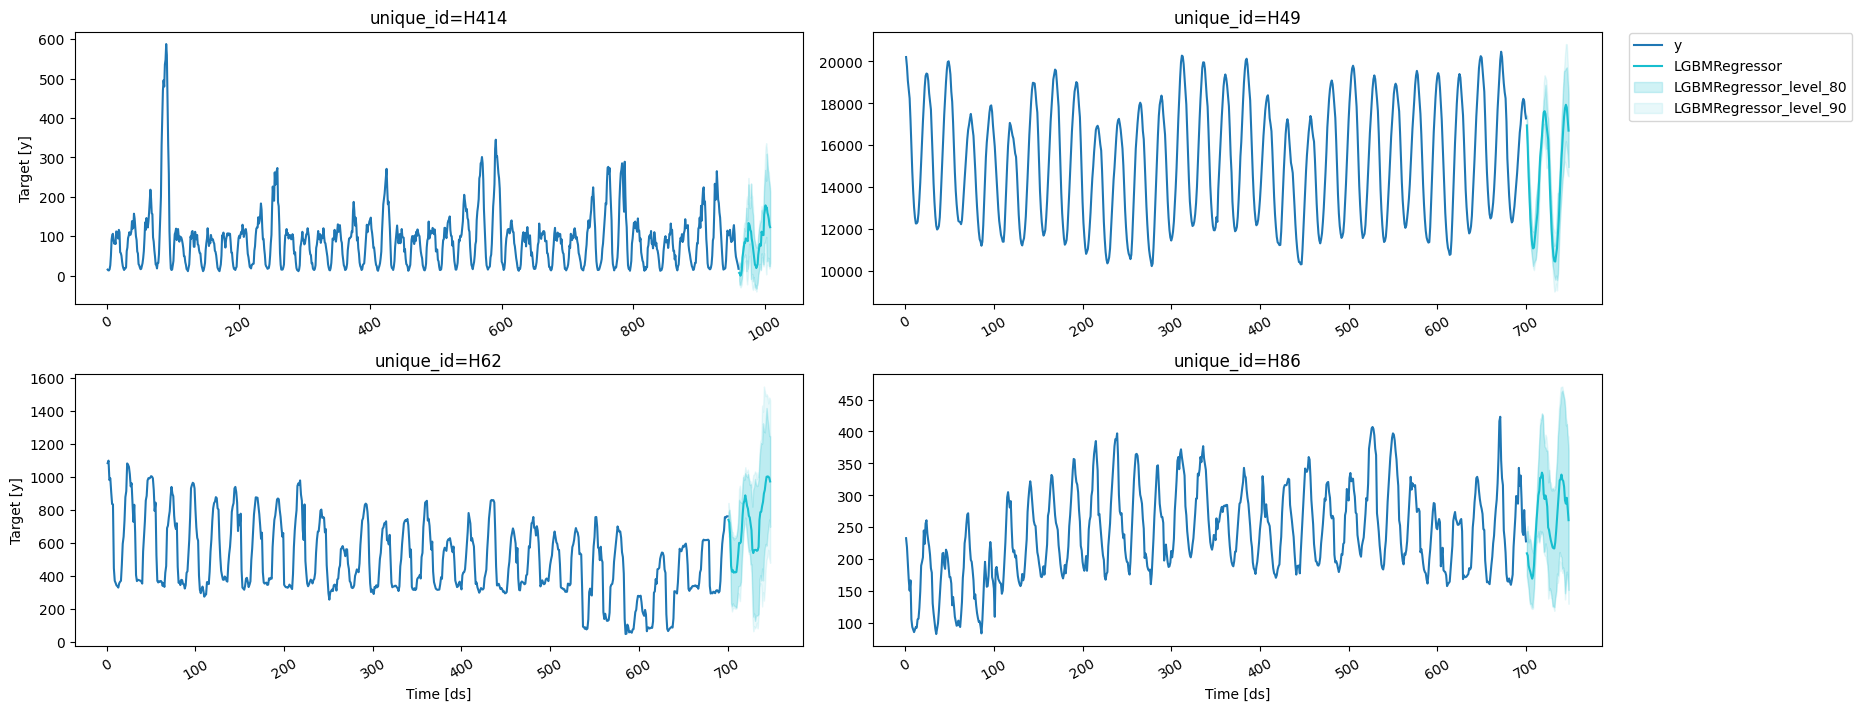


Results for LinearRegression:


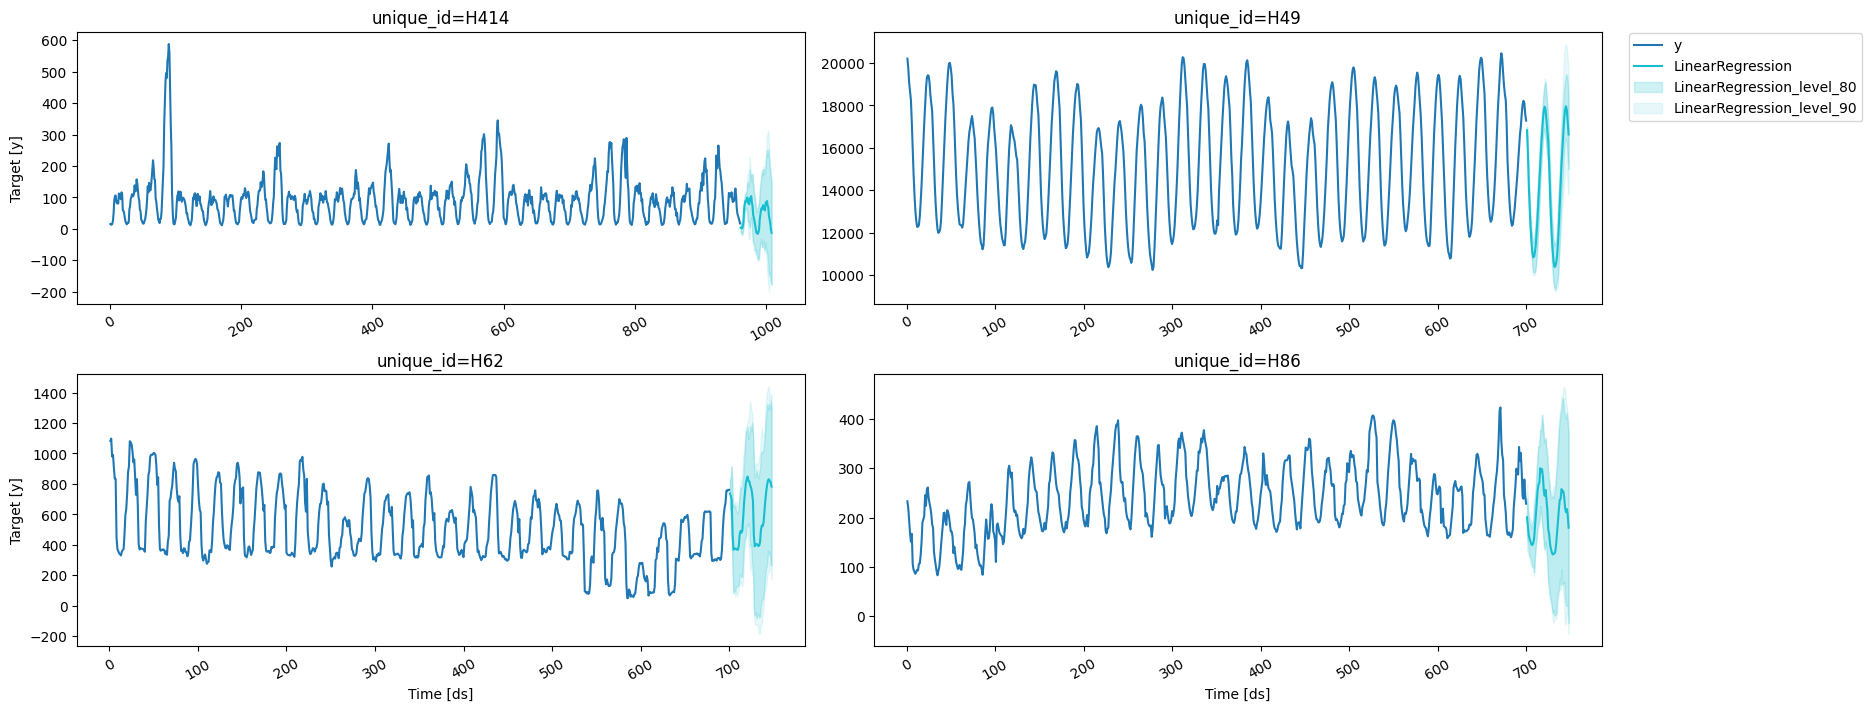


Results for Lasso:


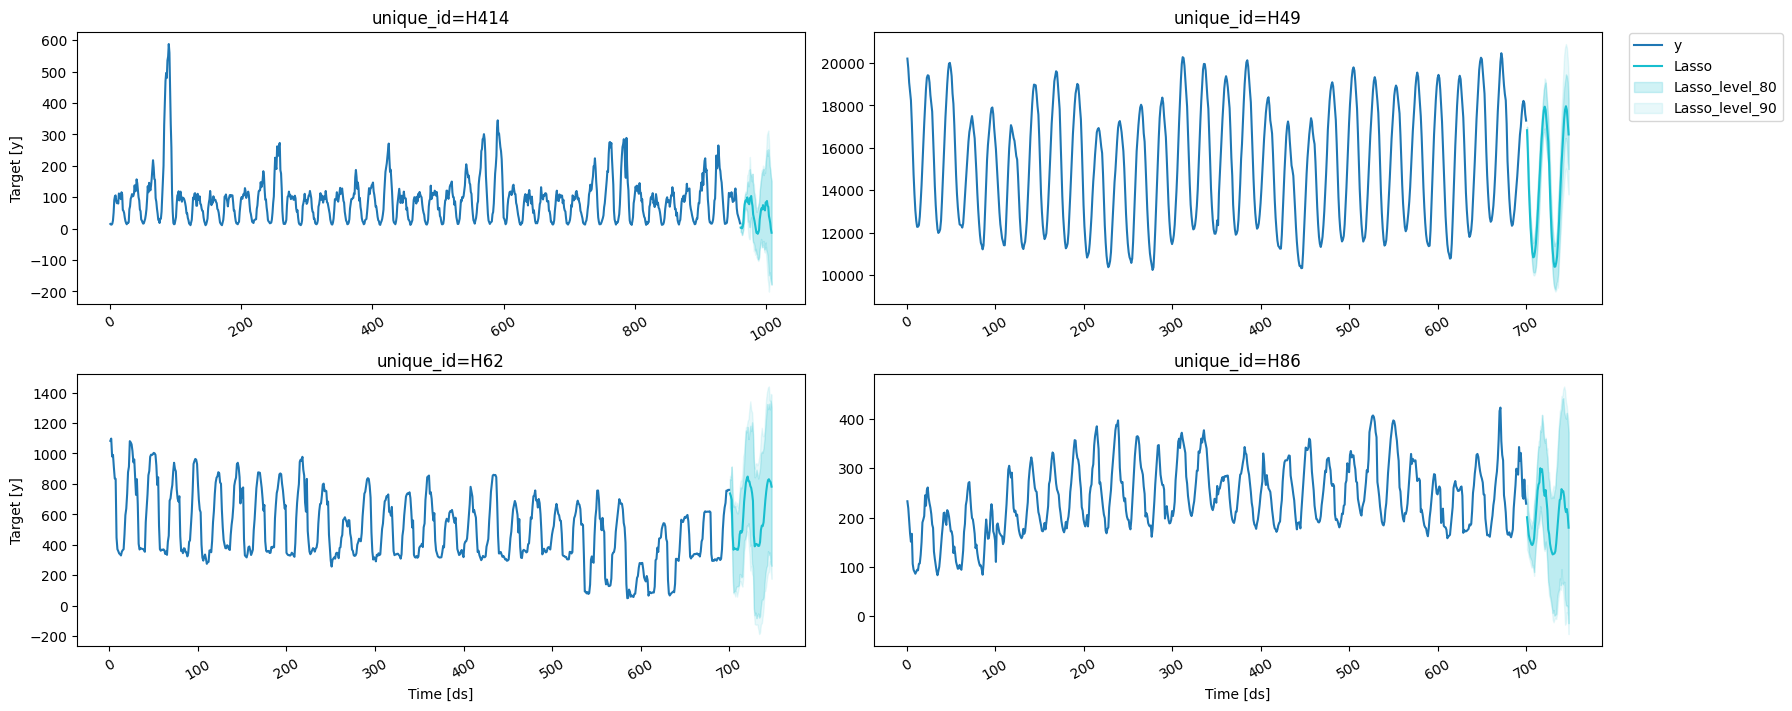


Results for Ridge:


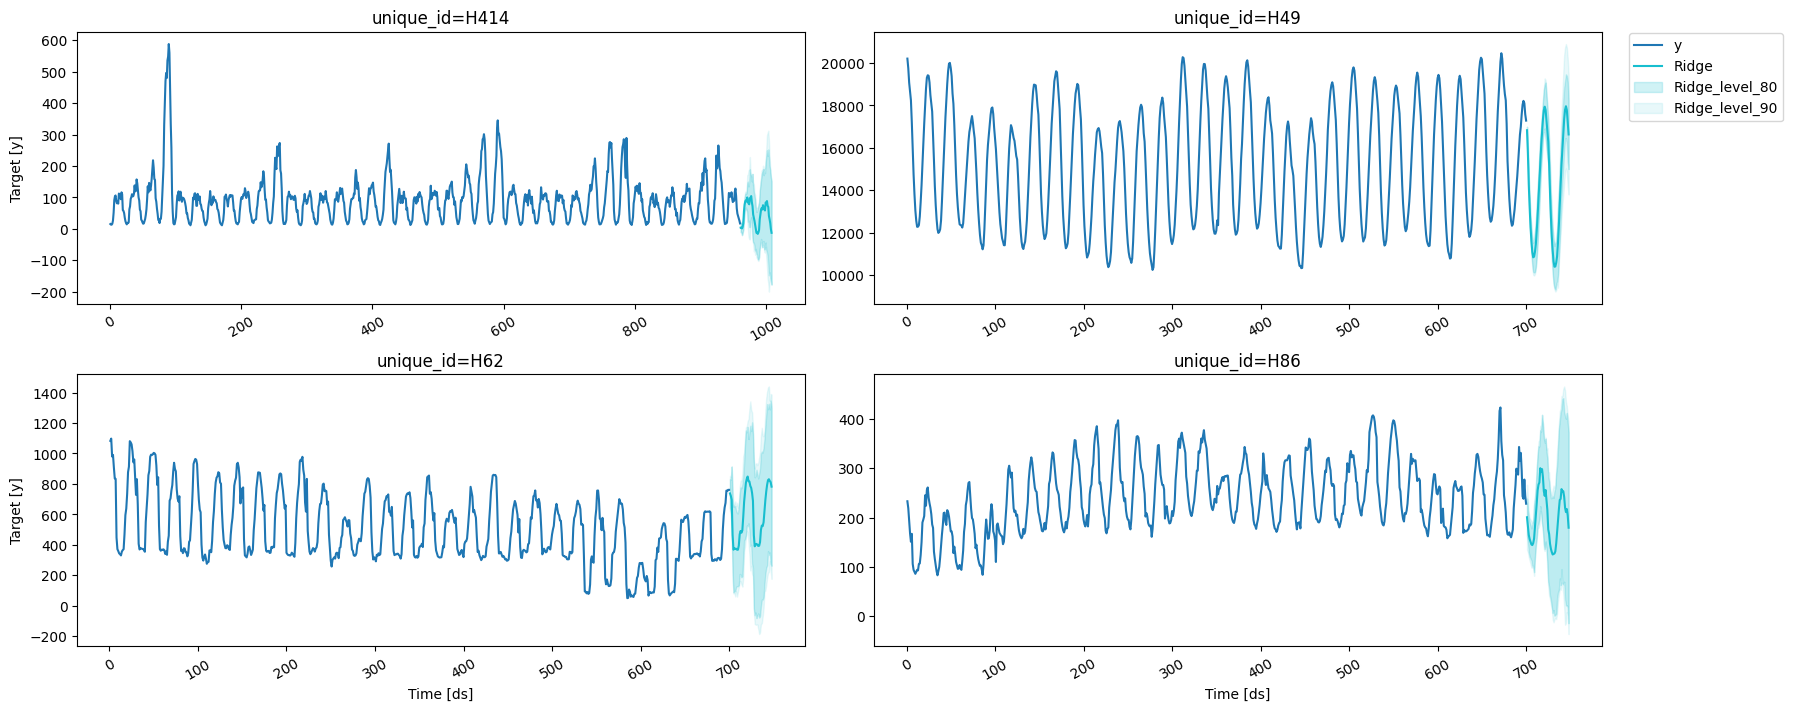


Results for RandomForestRegressor:


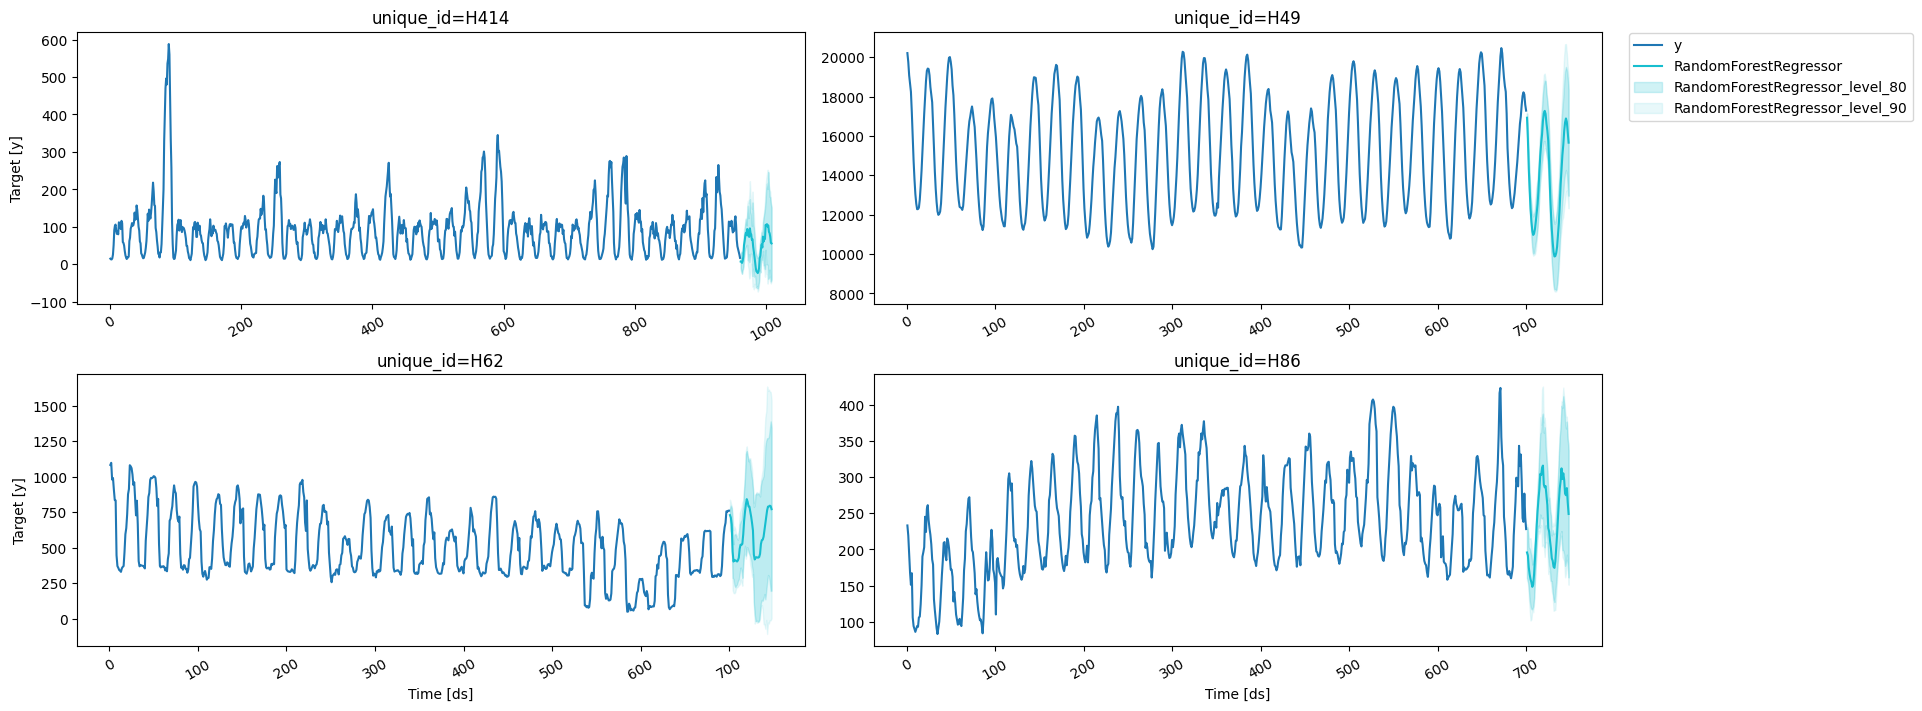


Results for XGBRegressor:


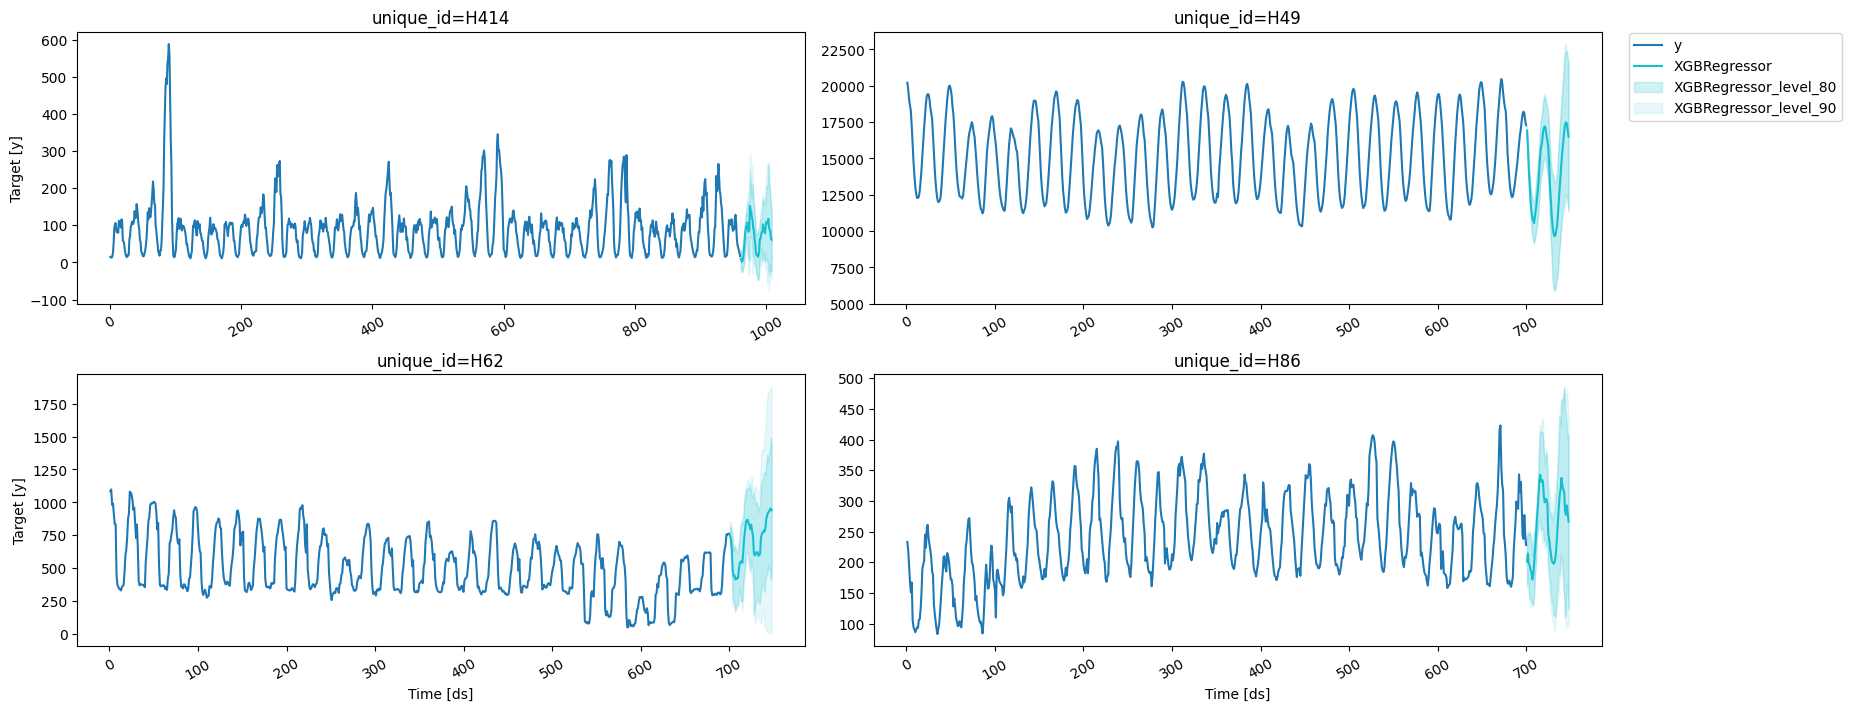


Results for KNeighborsRegressor:


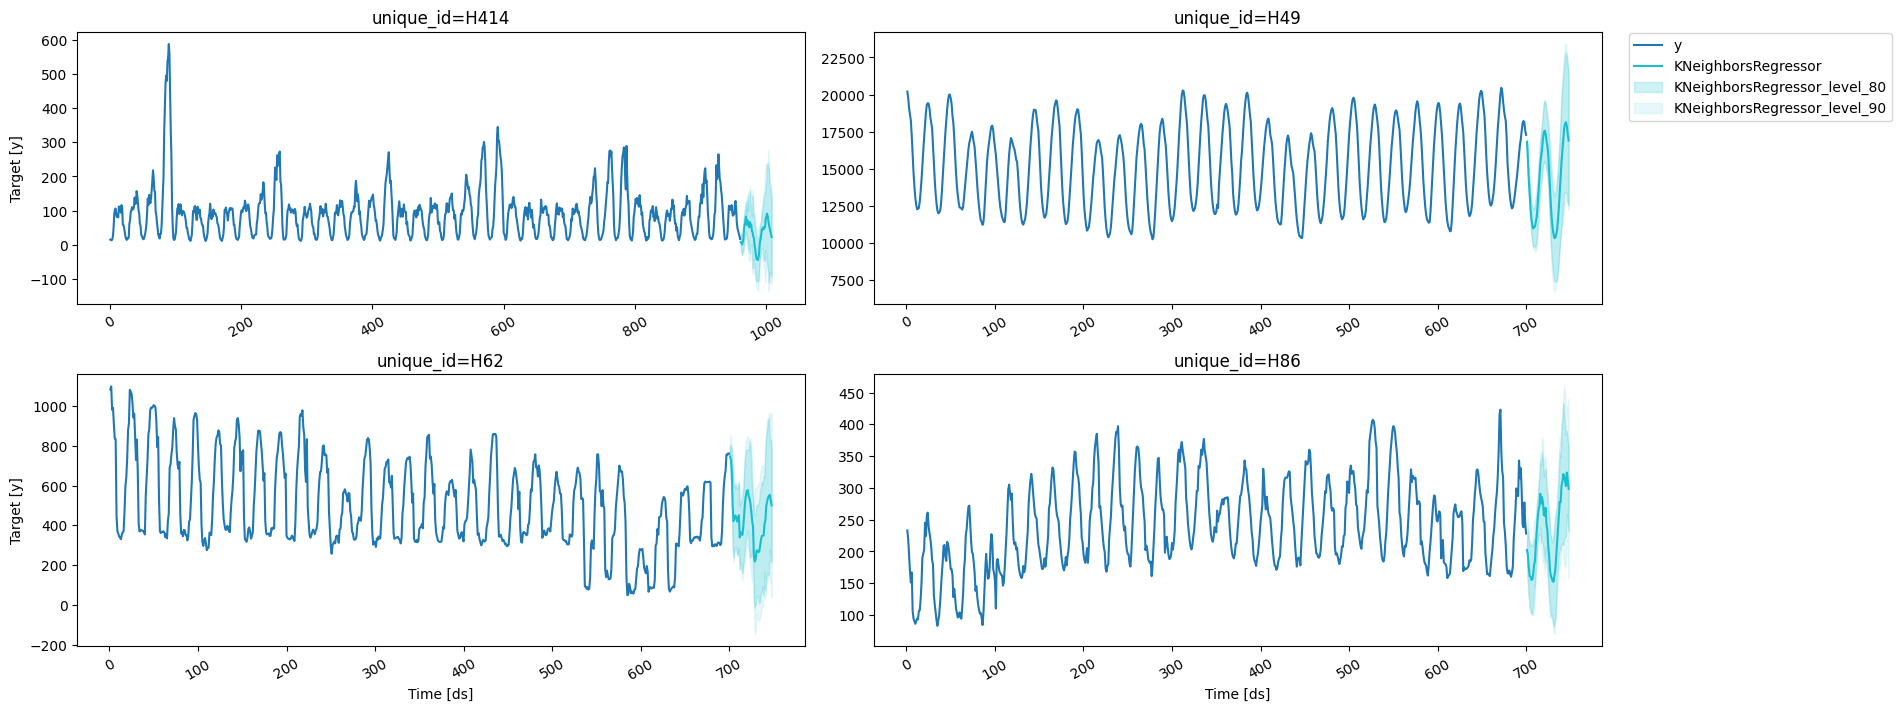

In [28]:
# Plot all results
print("Original Data:")
display(plot_series(train, test, plot_random=False, models=['y_test']))
print("\nResults for LGBMRegressor:")
display(plot_series(train, test_mlf, plot_random=False, models=["LGBMRegressor"], level=levels))
print("\nResults for LinearRegression:")
display(plot_series(train, test_mlf, plot_random=False, models=["LinearRegression"], level=levels))
print("\nResults for Lasso:")
display(plot_series(train, test_mlf, plot_random=False, models=["Lasso"], level=levels))
print("\nResults for Ridge:")
display(plot_series(train, test_mlf, plot_random=False, models=["Ridge"], level=levels))
print("\nResults for RandomForestRegressor:")
display(plot_series(train, test_mlf, plot_random=False, models=["RandomForestRegressor"], level=levels))
print("\nResults for XGBRegressor:")
display(plot_series(train, test_mlf, plot_random=False, models=["XGBRegressor"], level=levels))
print("\nResults for KNeighborsRegressor:")
display(plot_series(train, test_mlf, plot_random=False, models=["KNeighborsRegressor"], level=levels))

In [29]:
# Extract actual test data
ts_index = 0
uid_series_to_plot = uids.iloc[ts_index]
test_series = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'y_test']]

In [30]:
# Extract the forecasts
lgbm_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'LGBMRegressor']]
linreg_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'LinearRegression']]
lasso_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'Lasso']]
ridge_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'Ridge']]
rf_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'RandomForestRegressor']]
xgb_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'XGBRegressor']]
knn_forecast = test_mlf[test_mlf['unique_id'] == uid_series_to_plot][['ds', 'KNeighborsRegressor']]

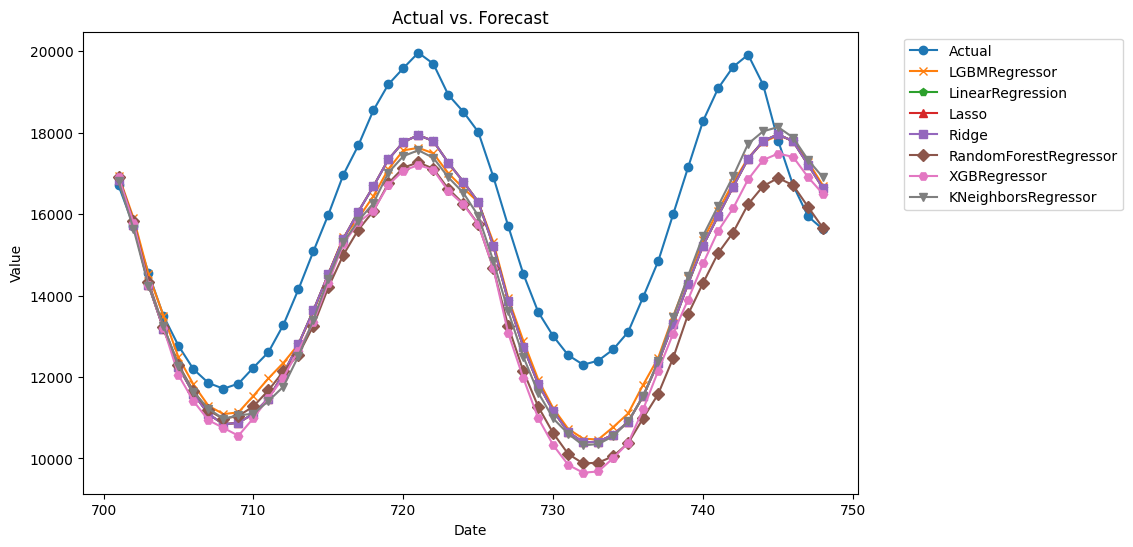

In [31]:
# Plot the ts objects
plt.figure(figsize=(10, 6))
plt.plot(test_series['ds'], test_series['y_test'], label='Actual', marker='o')
plt.plot(lgbm_forecast['ds'], lgbm_forecast['LGBMRegressor'], label='LGBMRegressor', marker='x')
plt.plot(linreg_forecast['ds'], linreg_forecast['LinearRegression'], label='LinearRegression', marker='p')
plt.plot(lasso_forecast['ds'], lasso_forecast['Lasso'], label='Lasso', marker='^')
plt.plot(ridge_forecast['ds'], ridge_forecast['Ridge'], label='Ridge', marker='s')
plt.plot(rf_forecast['ds'], rf_forecast['RandomForestRegressor'], label='RandomForestRegressor', marker='D')
plt.plot(xgb_forecast['ds'], xgb_forecast['XGBRegressor'], label='XGBRegressor', marker='H')
plt.plot(knn_forecast['ds'], knn_forecast['KNeighborsRegressor'], label='KNeighborsRegressor', marker='v')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecast')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [32]:
# Compute evaluation metrics
lgbm_rmse = root_mean_squared_error(test_series['y_test'], lgbm_forecast['LGBMRegressor'])
lgbm_mae = mean_absolute_error(test_series['y_test'], lgbm_forecast['LGBMRegressor'])
lgbm_mape = mean_absolute_percentage_error(test_series['y_test'], lgbm_forecast['LGBMRegressor'])

linreg_rmse = root_mean_squared_error(test_series['y_test'], linreg_forecast['LinearRegression'])
linreg_mae = mean_absolute_error(test_series['y_test'], linreg_forecast['LinearRegression'])
linreg_mape = mean_absolute_percentage_error(test_series['y_test'], linreg_forecast['LinearRegression'])

lasso_rmse = root_mean_squared_error(test_series['y_test'], lasso_forecast['Lasso'])
lasso_mae = mean_absolute_error(test_series['y_test'], lasso_forecast['Lasso'])
lasso_mape = mean_absolute_percentage_error(test_series['y_test'], lasso_forecast['Lasso'])

ridge_rmse = root_mean_squared_error(test_series['y_test'], ridge_forecast['Ridge'])
ridge_mae = mean_absolute_error(test_series['y_test'], ridge_forecast['Ridge'])
ridge_mape = mean_absolute_percentage_error(test_series['y_test'], ridge_forecast['Ridge'])

rf_rmse = root_mean_squared_error(test_series['y_test'], rf_forecast['RandomForestRegressor'])
rf_mae = mean_absolute_error(test_series['y_test'], rf_forecast['RandomForestRegressor'])
rf_mape = mean_absolute_percentage_error(test_series['y_test'], rf_forecast['RandomForestRegressor'])

xgb_rmse = root_mean_squared_error(test_series['y_test'], xgb_forecast['XGBRegressor'])
xgb_mae = mean_absolute_error(test_series['y_test'], xgb_forecast['XGBRegressor'])
xgb_mape = mean_absolute_percentage_error(test_series['y_test'], xgb_forecast['XGBRegressor'])

knn_rmse = root_mean_squared_error(test_series['y_test'], knn_forecast['KNeighborsRegressor'])
knn_mae = mean_absolute_error(test_series['y_test'], knn_forecast['KNeighborsRegressor'])
knn_mape = mean_absolute_percentage_error(test_series['y_test'], knn_forecast['KNeighborsRegressor'])

In [33]:
# Create DataFrame
metrics_mlf = pd.DataFrame({
    'Model': mlf_model_names,
    'RMSE': [lgbm_rmse, linreg_rmse, lasso_rmse, ridge_rmse, rf_rmse, xgb_rmse, knn_rmse],
    'MAE': [lgbm_mae, linreg_mae, lasso_mae, ridge_mae, rf_rmse, xgb_mae, knn_mae],
    'MAPE': [lgbm_mape, linreg_mape, lasso_mape, ridge_mape, rf_mape, xgb_mape, knn_mape]
})
display(metrics_mlf)

Model         RMSE          MAE      MAPE
0          LGBMRegressor  1724.194157  1524.479678  0.095753
1       LinearRegression  1760.995526  1583.589778  0.101103
2                  Lasso  1760.883485  1583.513004  0.101099
3                  Ridge  1760.995512  1583.589766  0.101103
4  RandomForestRegressor  2257.390709  2257.390709  0.122046
5           XGBRegressor  2173.841581  1946.387565  0.124416
6    KNeighborsRegressor  1833.841823  1666.795833  0.106092

# NeuralForecast

In [34]:
# PyTorch settings
logging.getLogger('pytorch_lightning').setLevel(logging.ERROR)
torch.set_float32_matmul_precision('high')

In [35]:
# List of NF models
nf_models = [
    LSTM(input_size=3*horizon, h=horizon, loss=MQLoss(level=levels), max_steps=1000),
    NHITS(input_size=7*horizon, h=horizon, n_freq_downsample=[24, 12, 1], loss=MQLoss(level=levels), max_steps=2000)
]

INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:lightning_fabric.utilities.seed:Seed set to 1


In [36]:
# List of NF model names
nf_model_names = [
    "LSTM",
    "NHITS"
]

In [37]:
# NF object
nf = NeuralForecast(
    models=nf_models,
    freq=1
)

In [38]:
# Fit the models
nf.fit(train)

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [39]:
# Get the forecasts
nf_forecasts = nf.predict()
nf_forecasts.head()

Predicting: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

unique_id   ds  LSTM-median  LSTM-lo-90  LSTM-lo-80  LSTM-hi-80  LSTM-hi-90  \
0      H414  961     8.766754   -0.788712    2.887550   15.214203   19.406387   
1      H414  962     7.681763    0.751678    3.116524   20.996086   30.451588   
2      H414  963    11.239250    1.405823    2.238426   27.666073   34.815975   
3      H414  964    17.935715    4.236160    4.558426   39.894135   46.867096   
4      H414  965    29.980255   10.531242   13.030548   52.134151   59.544041   

   NHITS-median  NHITS-lo-90  NHITS-lo-80  NHITS-hi-80  NHITS-hi-90  
0     19.355820    13.163551    14.763773    31.043455    36.599060  
1     18.288084     6.889822     7.046179    25.406597    26.003948  
2     20.328671     8.643295    15.014732    25.788347    31.342285  
3     25.459536    21.629242    18.752007    31.952991    32.021889  
4     36.757488    29.026760    27.937370    44.983322    58.026794

In [40]:
# Merge onto test set
test_nf = test_copy.merge(nf_forecasts, how='left', on=['unique_id', 'ds'])

In [41]:
# Rename LSTM-median to LSTM and NHITS-median to NHITS
test_nf.rename(columns={'LSTM-median': 'LSTM', 'NHITS-median': 'NHITS'}, inplace=True)
test_nf.head()

unique_id   ds  y_test       LSTM  LSTM-lo-90  LSTM-lo-80  LSTM-hi-80  \
0      H414  961    15.0   8.766754   -0.788712    2.887550   15.214203   
1      H414  962    12.0   7.681763    0.751678    3.116524   20.996086   
2      H414  963    11.0  11.239250    1.405823    2.238426   27.666073   
3      H414  964    17.0  17.935715    4.236160    4.558426   39.894135   
4      H414  965    31.0  29.980255   10.531242   13.030548   52.134151   

   LSTM-hi-90      NHITS  NHITS-lo-90  NHITS-lo-80  NHITS-hi-80  NHITS-hi-90  
0   19.406387  19.355820    13.163551    14.763773    31.043455    36.599060  
1   30.451588  18.288084     6.889822     7.046179    25.406597    26.003948  
2   34.815975  20.328671     8.643295    15.014732    25.788347    31.342285  
3   46.867096  25.459536    21.629242    18.752007    31.952991    32.021889  
4   59.544041  36.757488    29.026760    27.937370    44.983322    58.026794

Original Data:


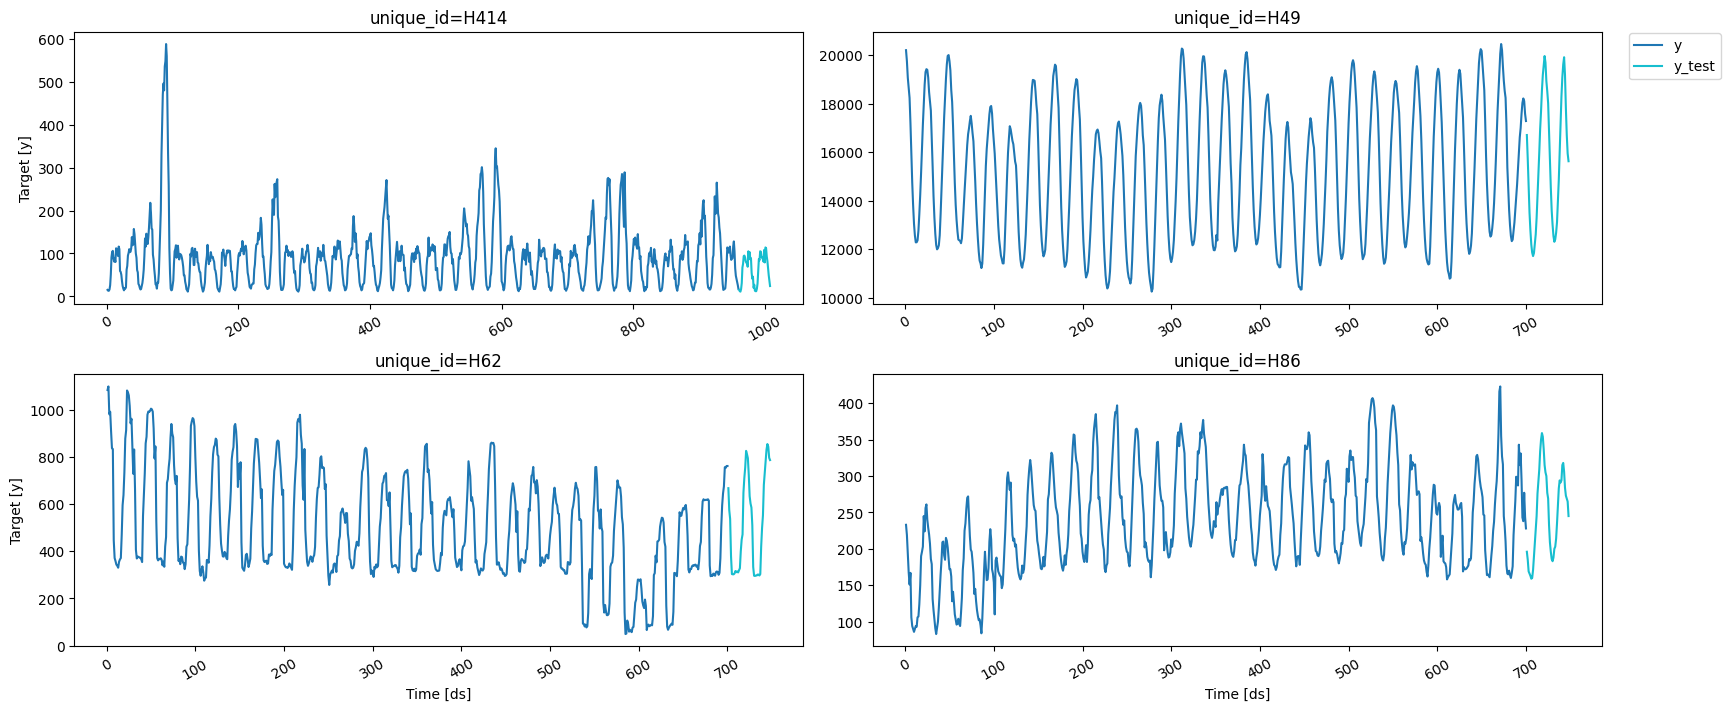


Results for LSTM:


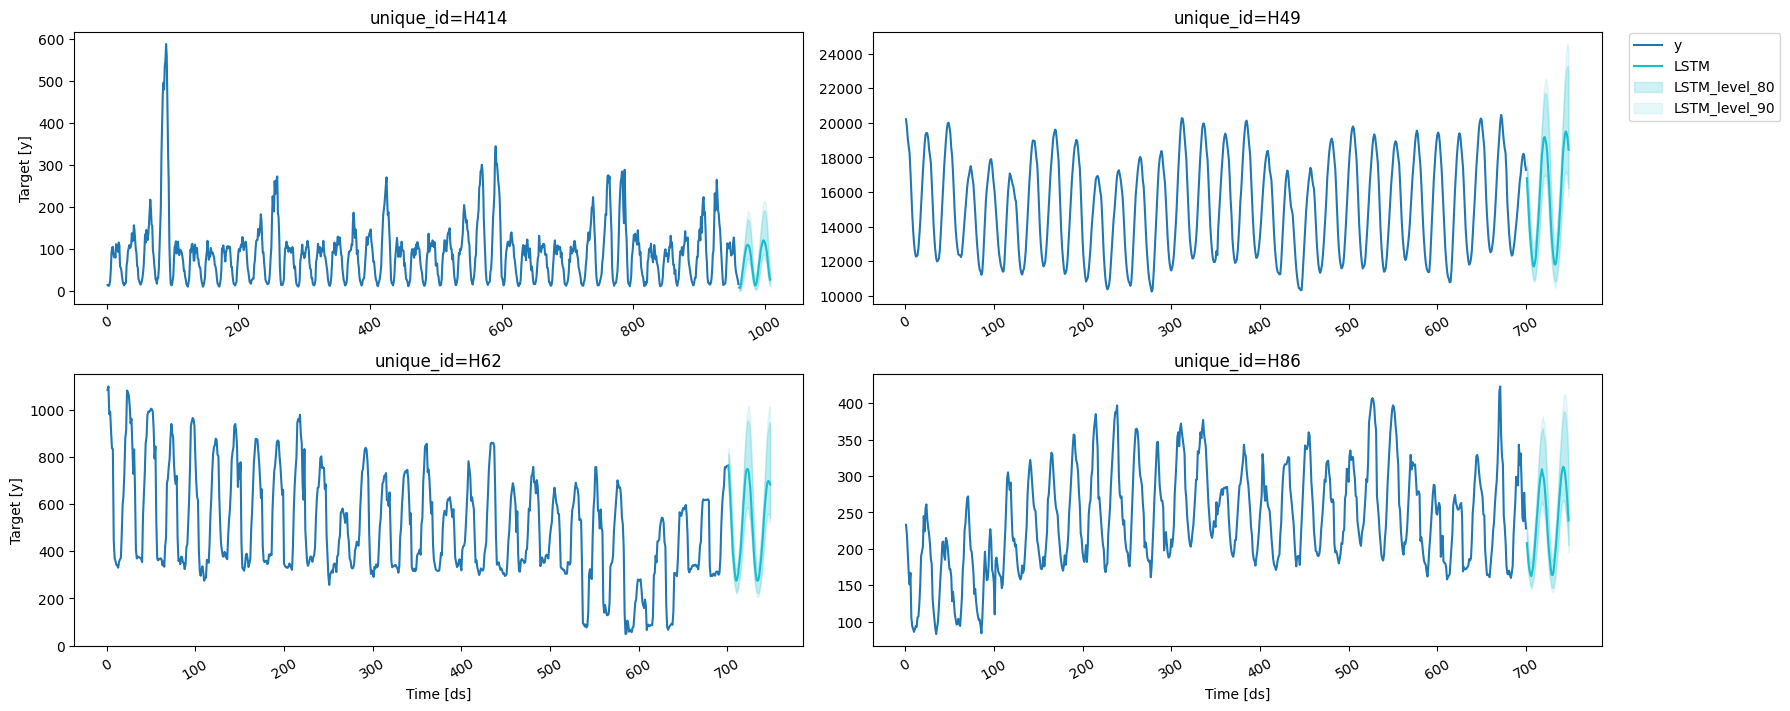


Results for NHITS:


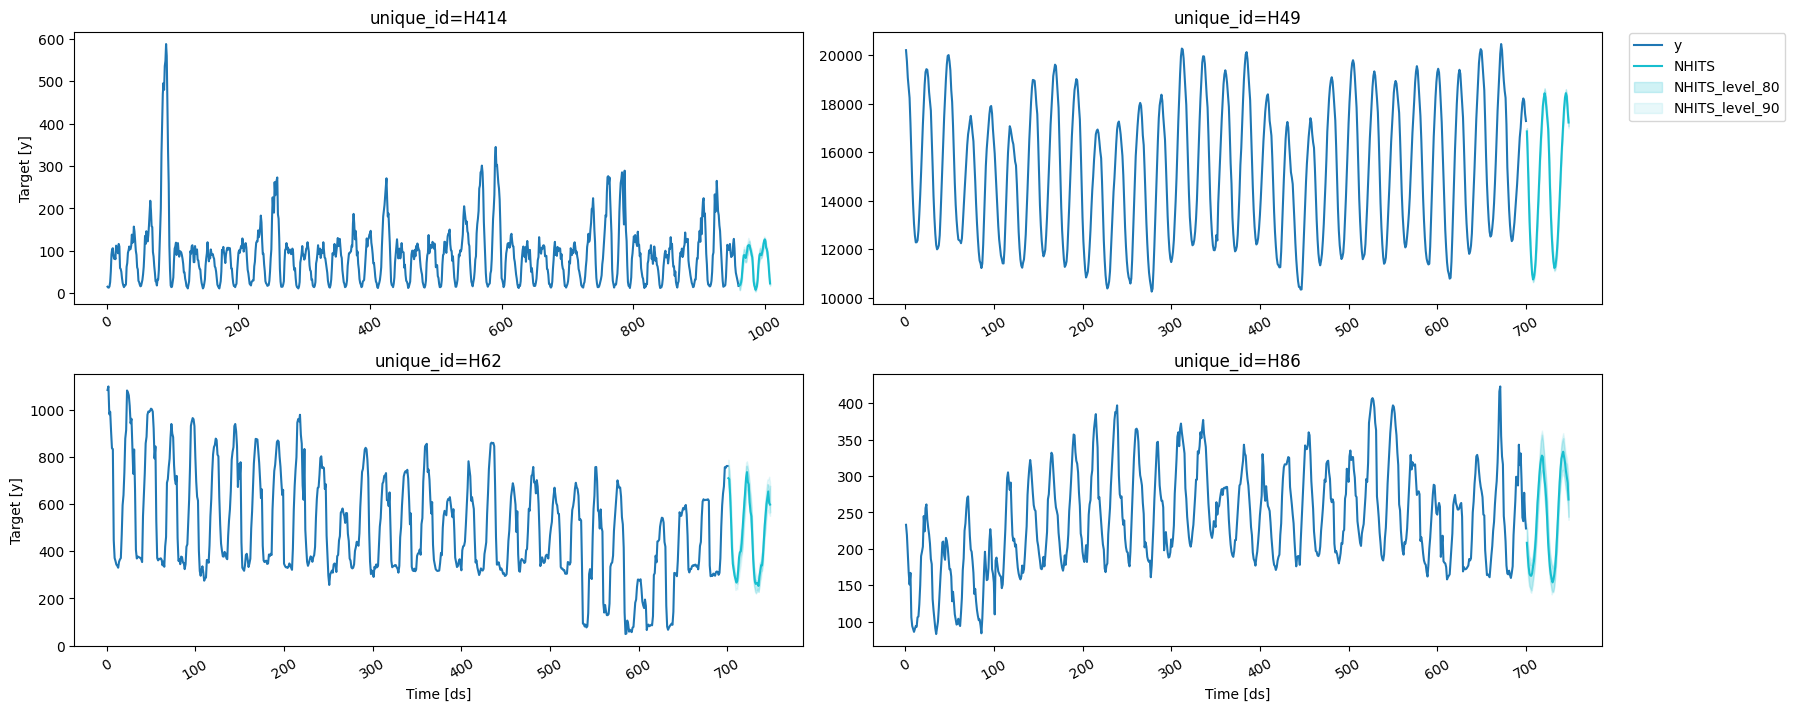

In [42]:
# Plot all results
print("Original Data:")
display(plot_series(train, test, plot_random=False, models=['y_test']))
print("\nResults for LSTM:")
display(plot_series(train, test_nf, plot_random=False, models=["LSTM"], level=levels))
print("\nResults for NHITS:")
display(plot_series(train, test_nf, plot_random=False, models=["NHITS"], level=levels))

In [43]:
# Extract actual test data
ts_index = 0
uid_series_to_plot = uids.iloc[ts_index]
test_series = test_nf[test_nf['unique_id'] == uid_series_to_plot][['ds', 'y_test']]

In [44]:
# Extract the forecasts
lstm_forecast = test_nf[test_nf['unique_id'] == uid_series_to_plot][['ds', 'LSTM']]
nhits_forecast = test_nf[test_nf['unique_id'] == uid_series_to_plot][['ds', 'NHITS']]

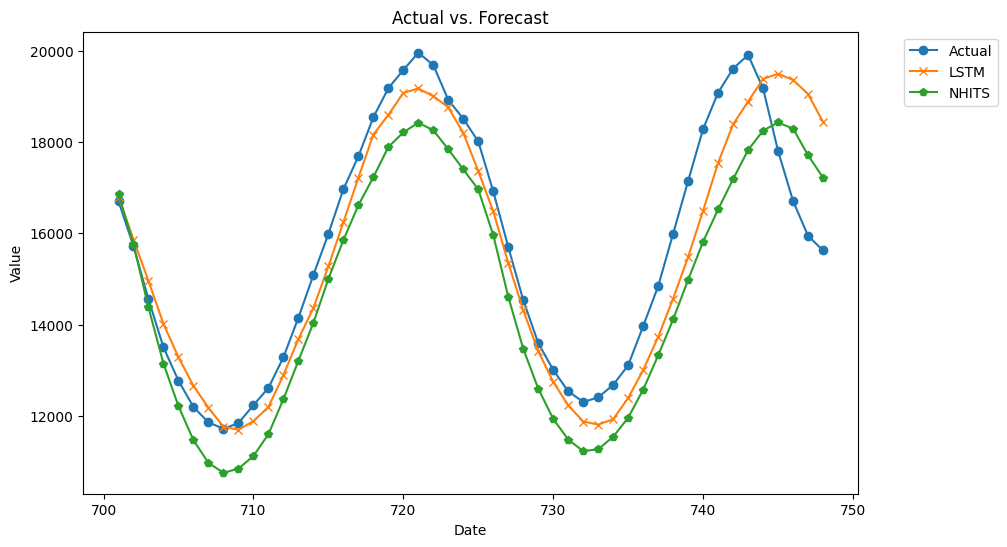

In [45]:
# Plot the ts objects
plt.figure(figsize=(10, 6))
plt.plot(test_series['ds'], test_series['y_test'], label='Actual', marker='o')
plt.plot(lstm_forecast['ds'], lstm_forecast['LSTM'], label='LSTM', marker='x')
plt.plot(nhits_forecast['ds'], nhits_forecast['NHITS'], label='NHITS', marker='p')
plt.xlabel('Date')
plt.ylabel('Value')
plt.title('Actual vs. Forecast')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

In [46]:
# Compute evaluation metrics
lstm_rmse = root_mean_squared_error(test_series['y_test'], lstm_forecast['LSTM'])
lstm_mae = mean_absolute_error(test_series['y_test'], lstm_forecast['LSTM'])
lstm_mape = mean_absolute_percentage_error(test_series['y_test'], lstm_forecast['LSTM'])

nhits_rmse = root_mean_squared_error(test_series['y_test'], nhits_forecast['NHITS'])
nhits_mae = mean_absolute_error(test_series['y_test'], nhits_forecast['NHITS'])
nhits_mape = mean_absolute_percentage_error(test_series['y_test'], nhits_forecast['NHITS'])

In [47]:
# Create DataFrame
metrics_nf = pd.DataFrame({
    'Model': ['LSTM', 'NHITS'],
    'RMSE': [lstm_rmse, nhits_rmse],
    'MAE': [lstm_mae, nhits_mae],
    'MAPE': [lstm_mape, nhits_mape]
})
display(metrics_nf)

Model         RMSE          MAE      MAPE
0   LSTM  1028.190772   759.401855  0.047538
1  NHITS  1305.906607  1188.415426  0.075567

In [48]:
# Compare all performances
metrics_all = pd.concat([metrics_sf, metrics_mlf, metrics_nf], ignore_index=True)
metrics_all.sort_values(by='RMSE', inplace=True)
display(metrics_all)

Model         RMSE          MAE      MAPE
0                 AutoETS   922.684876   733.708900  0.045778
3             HoltWinters   925.170918   749.549441  0.046576
1               AutoARIMA   964.466169   748.392122  0.046860
14                   LSTM  1028.190772   759.401855  0.047538
2               AutoTBATS  1036.048753   876.029539  0.054940
5   DynamicOptimizedTheta  1164.524739  1022.072019  0.063989
4           SeasonalNaive  1176.720150  1176.720150  0.055287
15                  NHITS  1305.906607  1188.415426  0.075567
7           LGBMRegressor  1724.194157  1524.479678  0.095753
9                   Lasso  1760.883485  1583.513004  0.101099
10                  Ridge  1760.995512  1583.589766  0.101103
8        LinearRegression  1760.995526  1583.589778  0.101103
13    KNeighborsRegressor  1833.841823  1666.795833  0.106092
12           XGBRegressor  2173.841581  1946.387565  0.124416
11  RandomForestRegressor  2257.390709  2257.390709  0.122046
6     RandomWalkWithDrift  3079.001868  2620.732207  0.187056

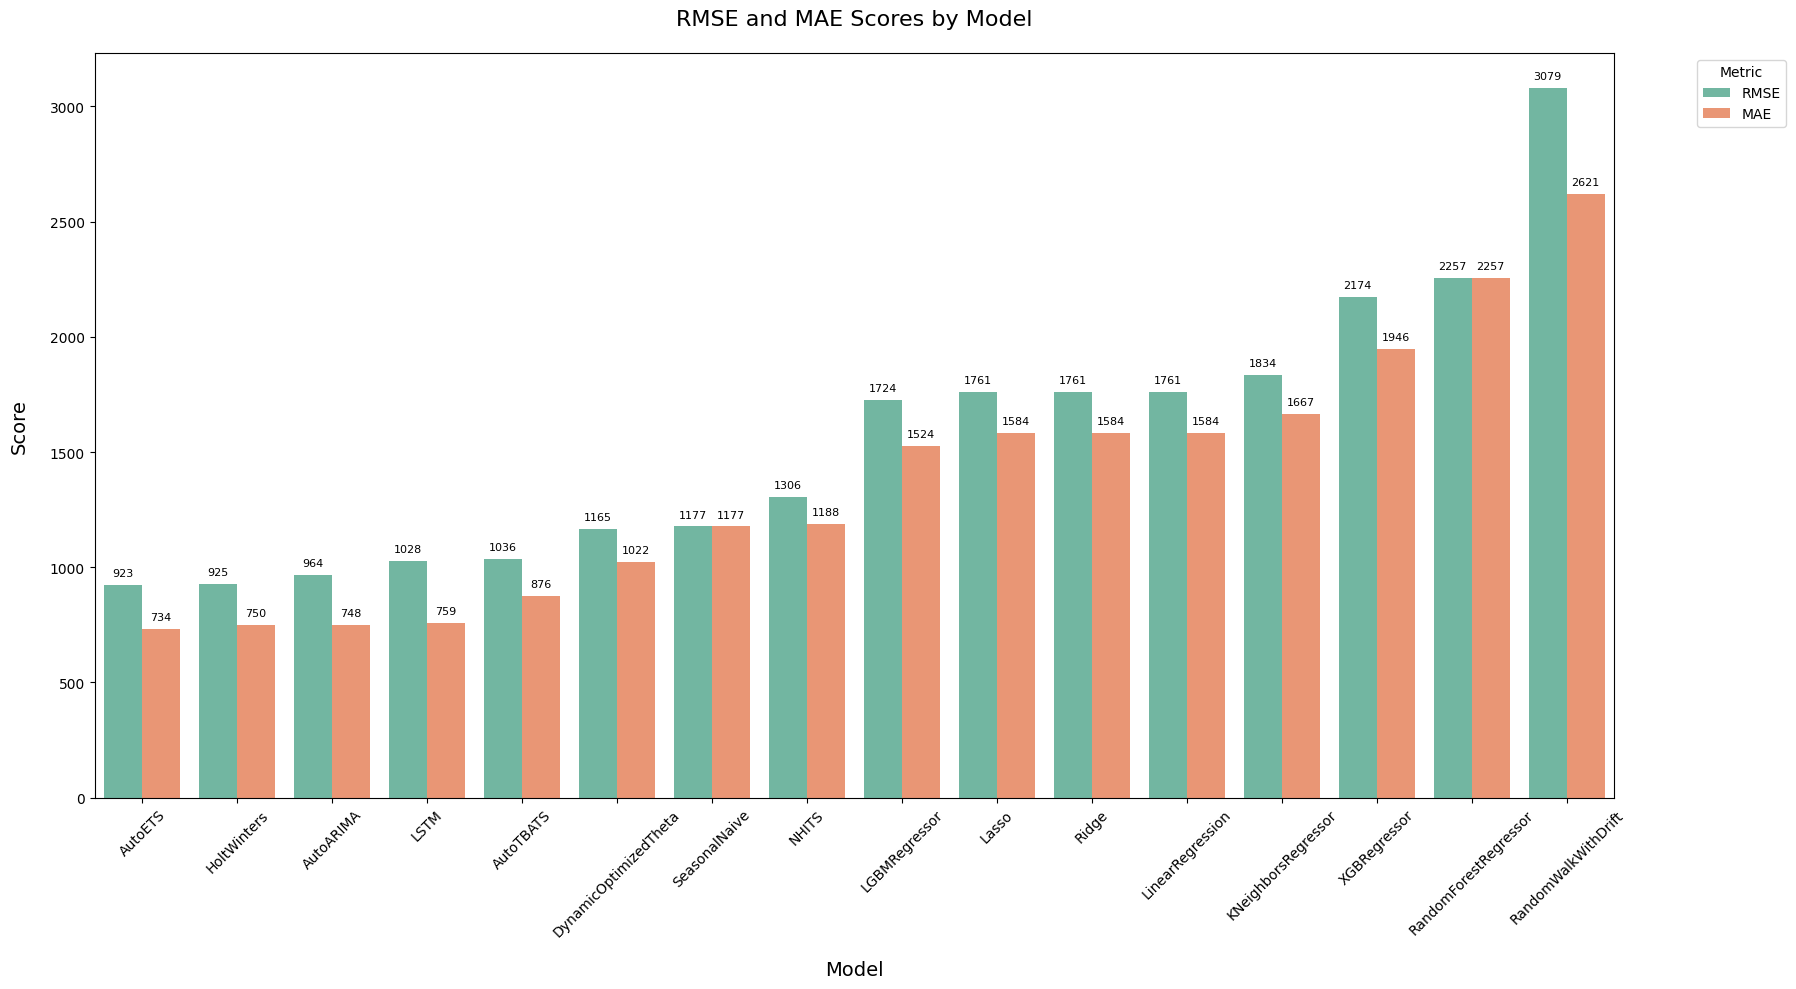

In [49]:
# Select the relevant columns
metrics_plot = metrics_all[['Model', 'RMSE', 'MAE']]

# Melt the DataFrame to long format
metrics_melted = metrics_plot.melt(
    id_vars='Model',
    value_vars=['RMSE', 'MAE'],
    var_name='Metric',
    value_name='Score'
)

# Sort models by RMSE
sorted_models = metrics_all.sort_values('RMSE')['Model']
metrics_melted['Model'] = pd.Categorical(metrics_melted['Model'], categories=sorted_models, ordered=True)

# Set the figure size
plt.figure(figsize=(18, 10))

# Create the grouped bar plot
bar_plot = sns.barplot(
    data=metrics_melted,
    x='Model',
    y='Score',
    hue='Metric',
    palette='Set2'
)

# Annotate each bar with the score value
for p in bar_plot.patches:
    if p.get_height() > 0:
        height = p.get_height()
        bar_plot.annotate(f'{height:.0f}',
                        (p.get_x() + p.get_width() / 2., height),
                        ha='center', va='bottom',
                        fontsize=8, color='black', rotation=0,
                        xytext=(0, 5),
                        textcoords='offset points')

plt.title('RMSE and MAE Scores by Model', fontsize=16, pad=20)
plt.xlabel('Model', fontsize=14, labelpad=15)
plt.ylabel('Score', fontsize=14, labelpad=15)
plt.xticks(rotation=45, fontsize=10)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()